In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
import logging
import sys
from glob import glob

import nibabel as nib
import numpy as np
import torch
from torch.nn.functional import pad
from torch.utils.data import DataLoader, Dataset

from monai import config
from monai.data import decollate_batch
from monai.networks.nets import UNet
from monai.transforms import (
    Activations,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    CenterSpatialCrop,
    ScaleIntensity,
    EnsureType,
    Transpose,
)
import pandas as pd
import matplotlib.pyplot as plt

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.current_device())

True
2
GeForce GTX 1080
0


## Visualization on Predicted Segmentation

In [2]:
os.chdir('/root/src/unet-with-monai/exp_04')

if not os.path.exists("./visualized-img/single_net"):
    os.makedirs("./visualized-img/single_net")
    
if not os.path.exists("./visualized-img/threshold"):
    os.makedirs("./visualized-img/threshold")

# config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)


data_dir = "../dataset/working_data"
test_dir = os.path.join(data_dir, 'Test')
single_net_gt_list = sorted(glob(os.path.join(test_dir, "case*", "task01_seg*.nii.gz")))
single_net_gt_list = sorted([i for i in single_net_gt_list if 'case09' not in i])


single_net_output_dir = './output/single_net'
single_net_output_list = sorted(glob(os.path.join(single_net_output_dir, "case*", "*.nii.gz")))

threshold_dir = './output/threshold'
threshold_output_list = sorted(glob(os.path.join(threshold_dir, "case*", "output*.nii.gz")))
threshold_gt_list = sorted(glob(os.path.join(threshold_dir, "case*", "gt*.nii.gz")))


imtrans_test = Compose(
    [
        LoadImage(image_only=True),
        ScaleIntensity(),
        Transpose((2, 0, 1)),
        # AddChannel(),
        # CenterSpatialCrop((640, 640)),
        # RandSpatialCrop((96, 96), random_size=False),
        EnsureType(),
    ]
)
segtrans_test = Compose(
    [
        LoadImage(image_only=True),
        Transpose((2, 1, 0)),
        # AddChannel(),
        # CenterSpatialCrop((640, 640)),
        # RandSpatialCrop((96, 96), random_size=False),
        EnsureType(),
    ]
)

segtrans_output = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        # Transpose((2, 0, 1)),
        # CenterSpatialCrop((640, 640)),
        # RandSpatialCrop((96, 96), random_size=False),
        EnsureType(),
    ]
)

class single_net_Dataset(Dataset):
    def __init__(self, output_list, gt_list, img_transform=None):
        self.output_list = output_list
        self.gt_list = gt_list
        self.img_transform = img_transform

    def __len__(self):
        return int(len(self.output_list)/6)

    def __getitem__(self, idx):      
        return self.img_transform(self.output_list[idx*6 : idx*6+6]), self.img_transform(self.gt_list[idx*6 : idx*6+6])

single_net_set = single_net_Dataset(single_net_output_list, single_net_gt_list, segtrans_test)
single_net_loader = DataLoader(single_net_set, batch_size=1, num_workers=4, shuffle=False)

class threshold_Dataset(Dataset):
    def __init__(self, output_list, gt_list, img_transform=None):
        self.output_list = output_list
        self.gt_list = gt_list
        self.img_transform = img_transform

    def __len__(self):
        return int(len(self.output_list)/9)

    def __getitem__(self, idx):      
        return self.img_transform(self.output_list[idx*9 : idx*9+9]), self.img_transform(self.gt_list[idx*9 : idx*9+9])

threshold_set = threshold_Dataset(threshold_output_list, threshold_gt_list, segtrans_test)
threshold_loader = DataLoader(threshold_set, batch_size=1, num_workers=4, shuffle=False)


single_net_dicesheet = pd.read_csv(os.path.join(single_net_output_dir, "single_net_dicesheet.csv"), index_col=0)
threshold_dicesheet= pd.read_csv(os.path.join(threshold_dir, "threshold_dicesheet.csv"),  index_col=0)

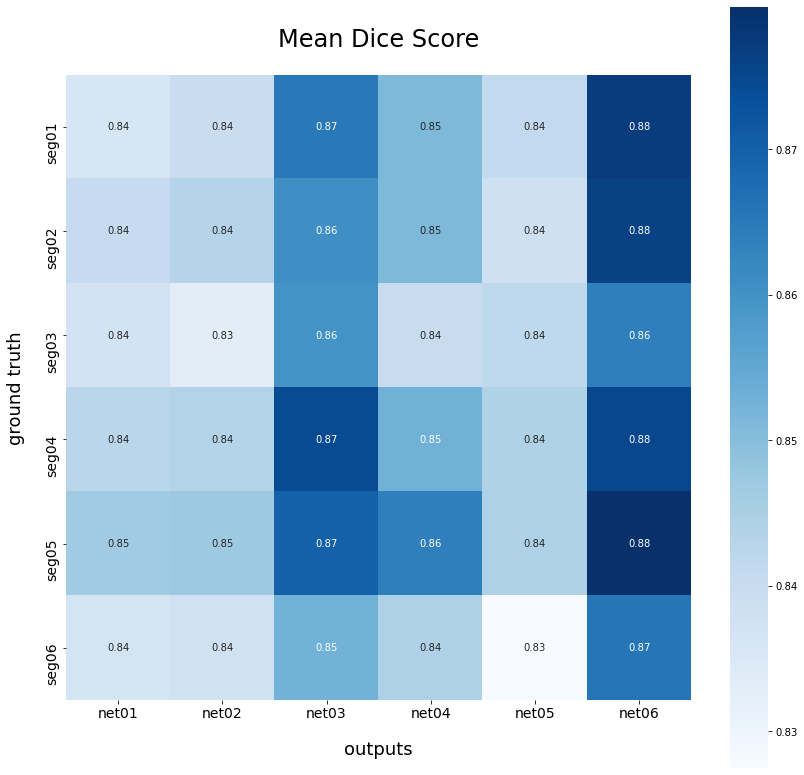

In [3]:
corr_dice_matrix = np.loadtxt(os.path.join(single_net_output_dir, "corr_dice_matrix.csv"), delimiter=",")
nets = ["net01", "net02", "net03", "net04", "net05", "net06"]
segs = ["seg01", "seg02", "seg03", "seg04", "seg05", "seg06"]
import seaborn as sns
plt.subplots(figsize=(14, 14))
sns.heatmap(corr_dice_matrix, annot=True, square=True, cmap="Blues")
plt.xticks(np.arange(6)+0.5, nets, fontsize=14)
plt.yticks(np.arange(6)+0.5, segs, fontsize=14)
plt.xlabel("outputs", fontsize = 18, labelpad=20)
plt.ylabel("ground truth", fontsize = 18, labelpad=20)
plt.title("Mean Dice Score", fontsize = 24, pad=28)
plt.savefig(os.path.join("./visualized-img/single_net", "corr_dice_matrix.pdf"), dpi=300)
plt.show()

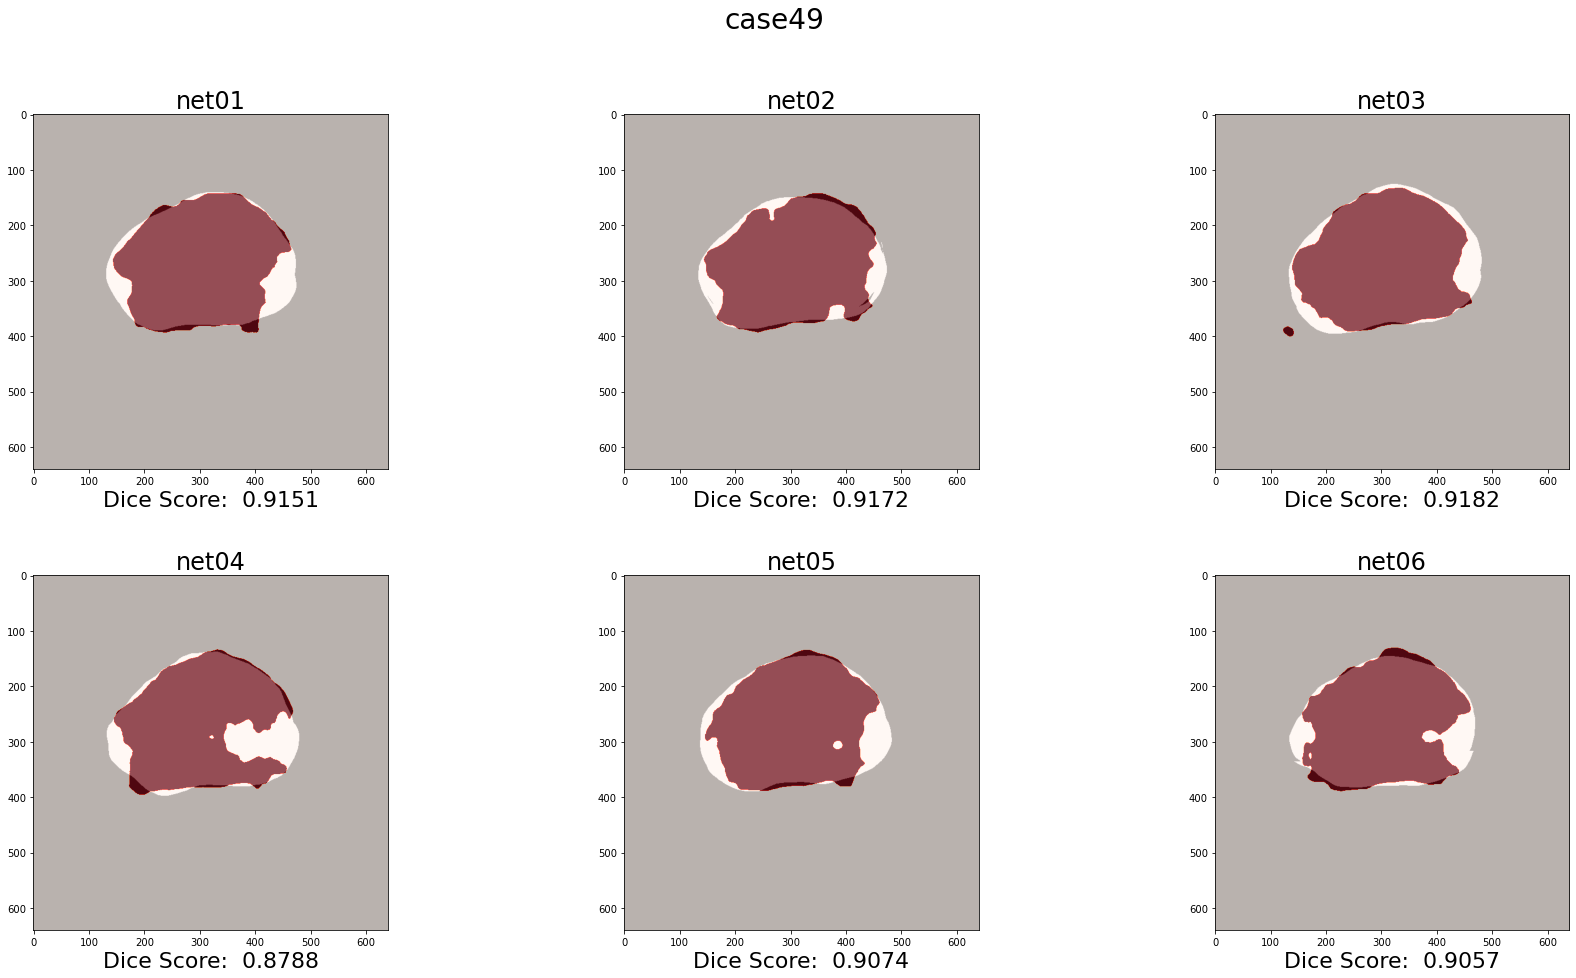

****************************************************************************************************


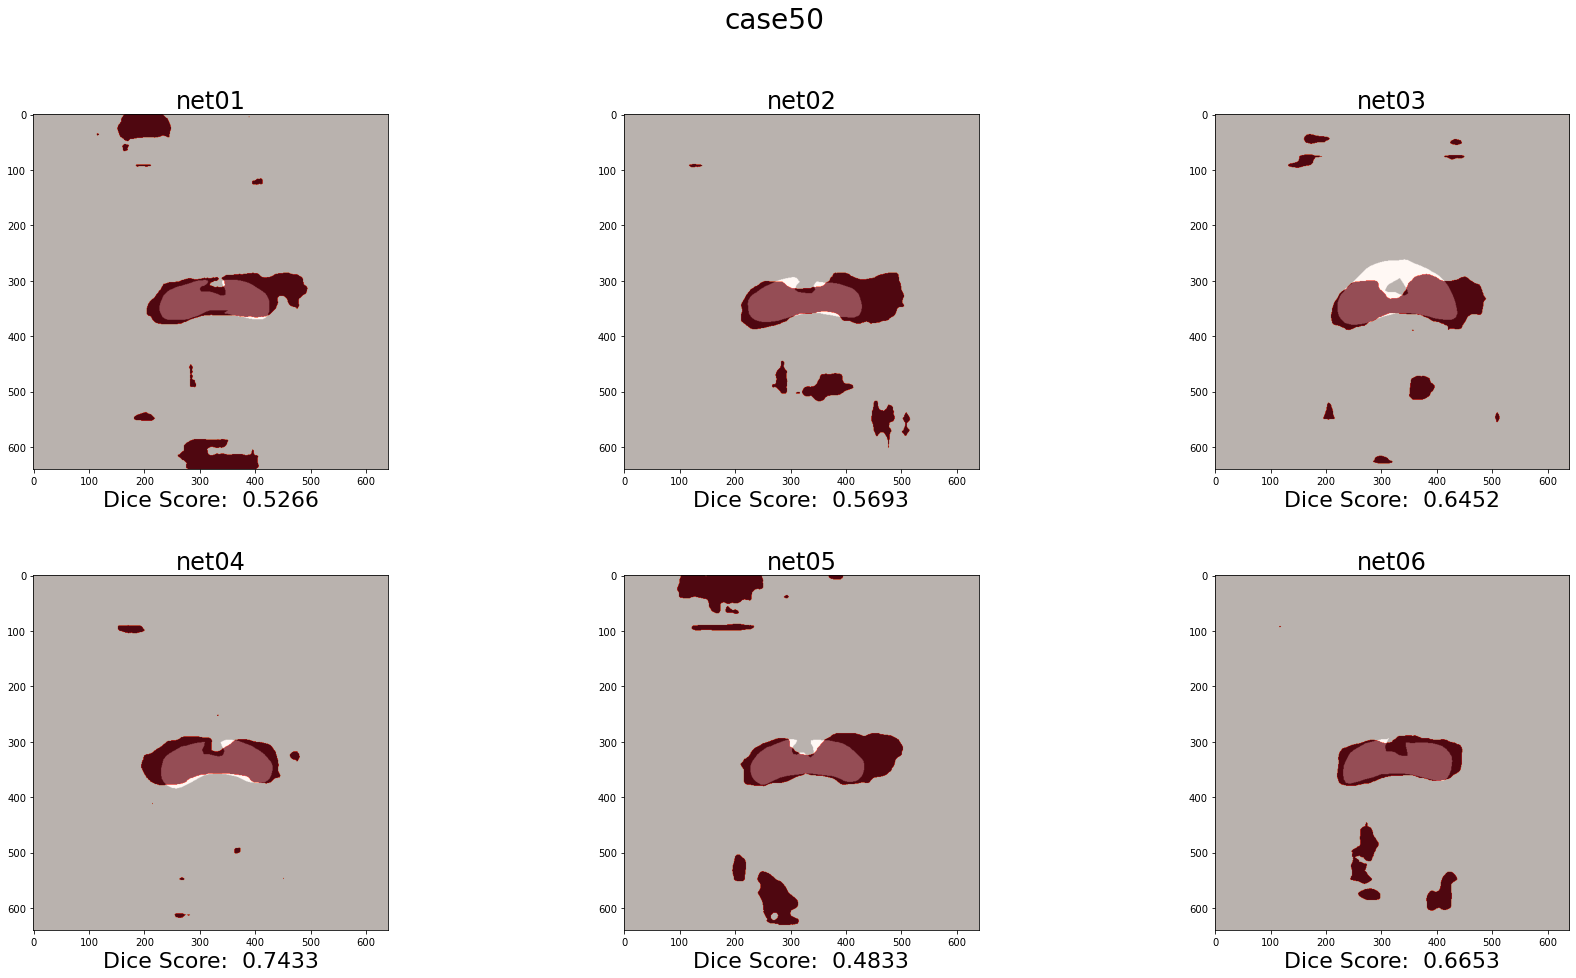

****************************************************************************************************


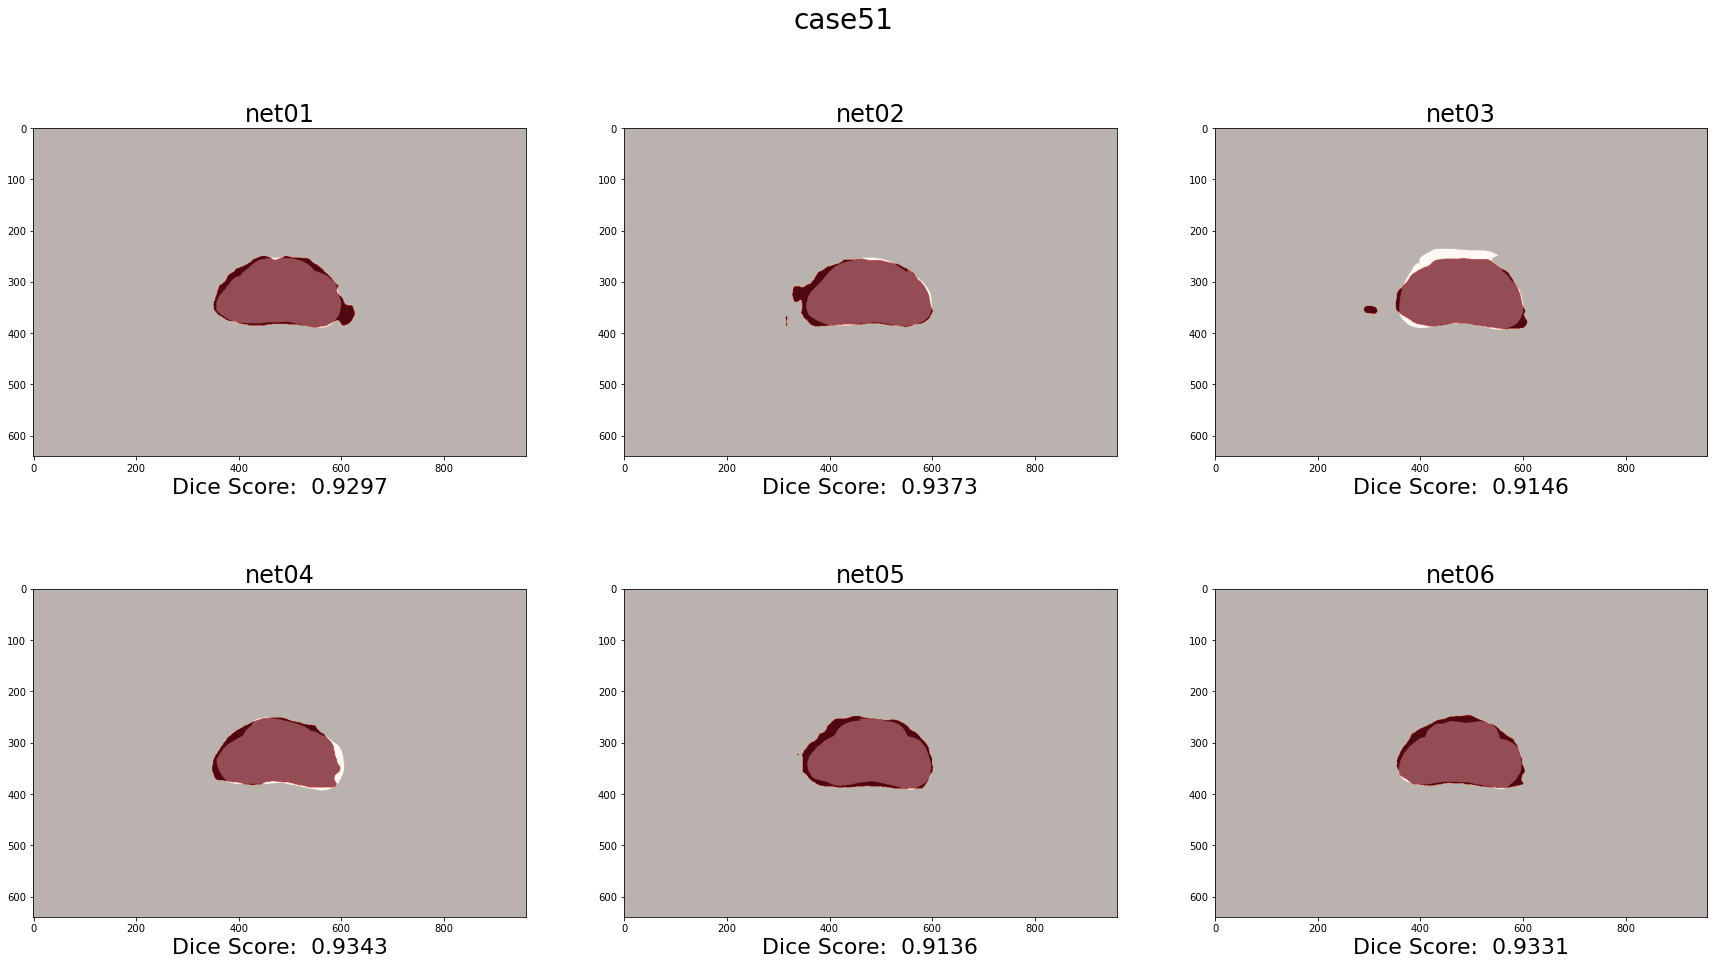

****************************************************************************************************


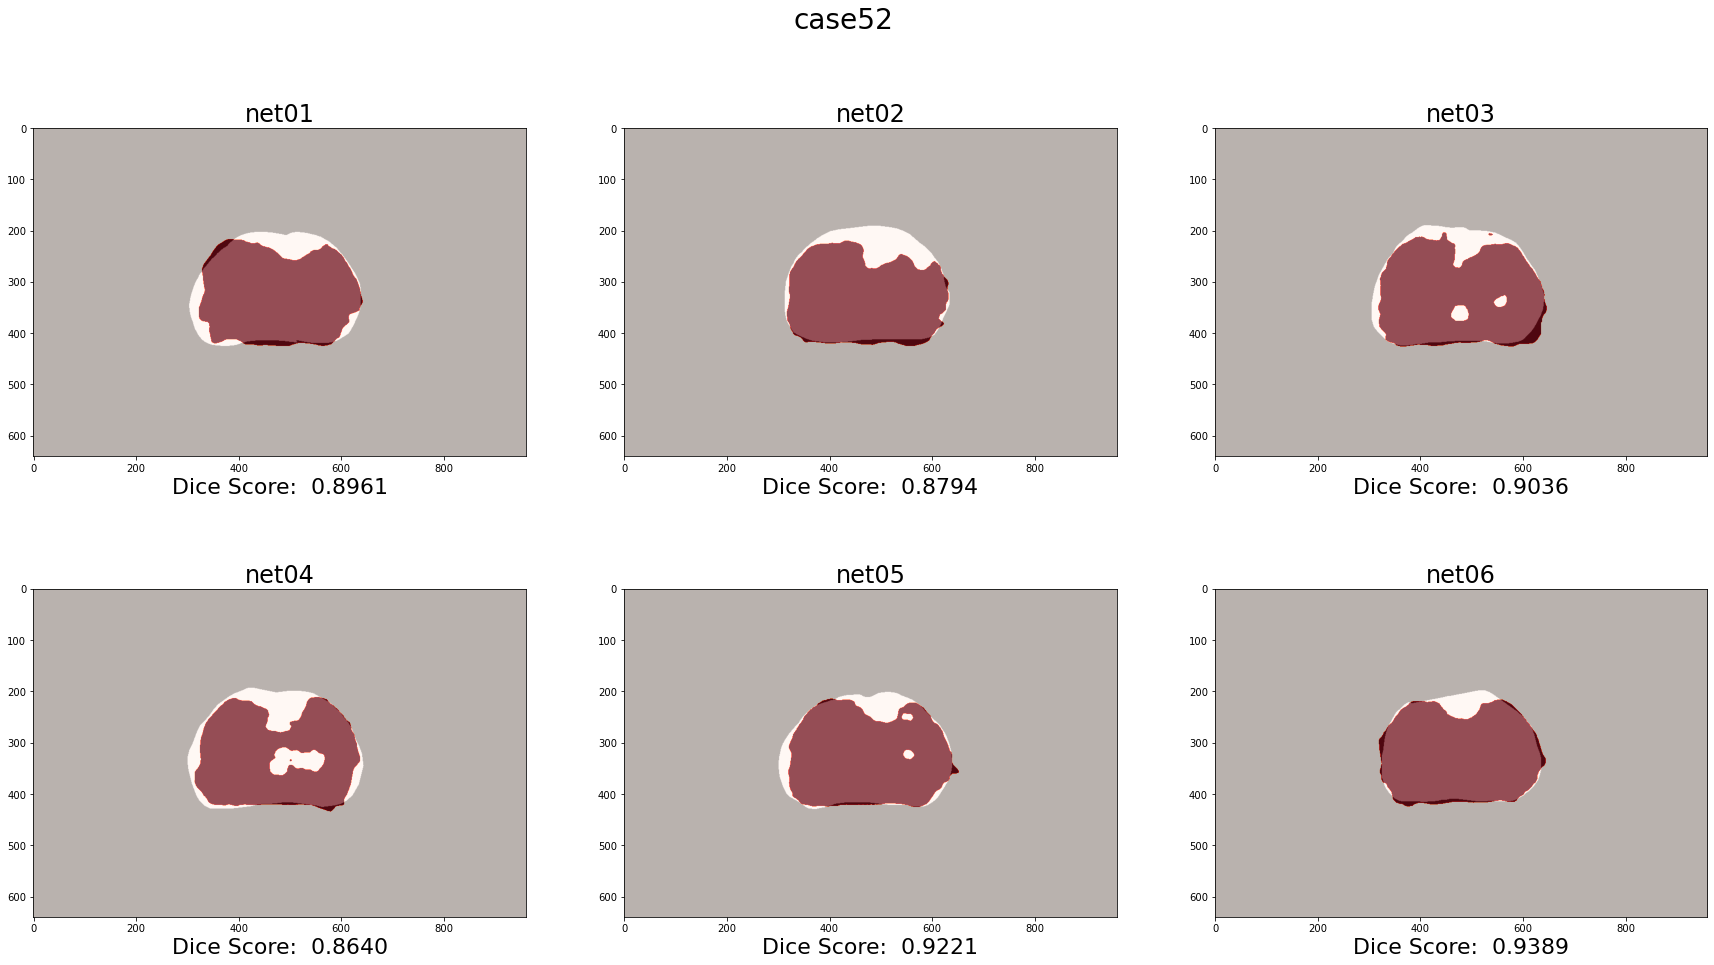

****************************************************************************************************


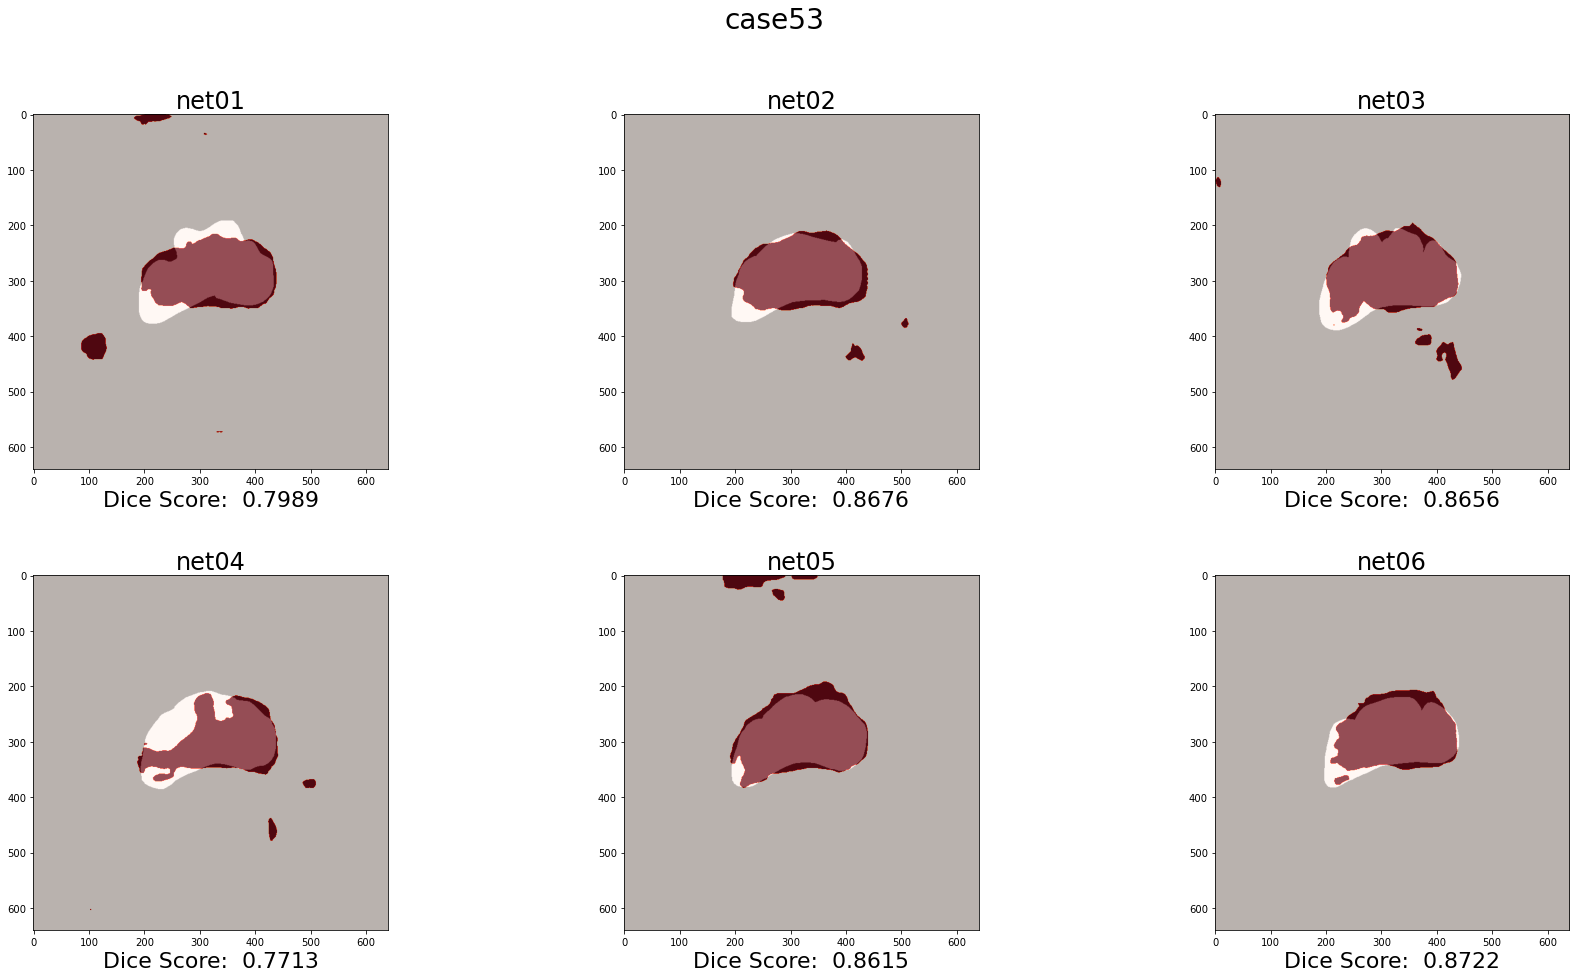

****************************************************************************************************


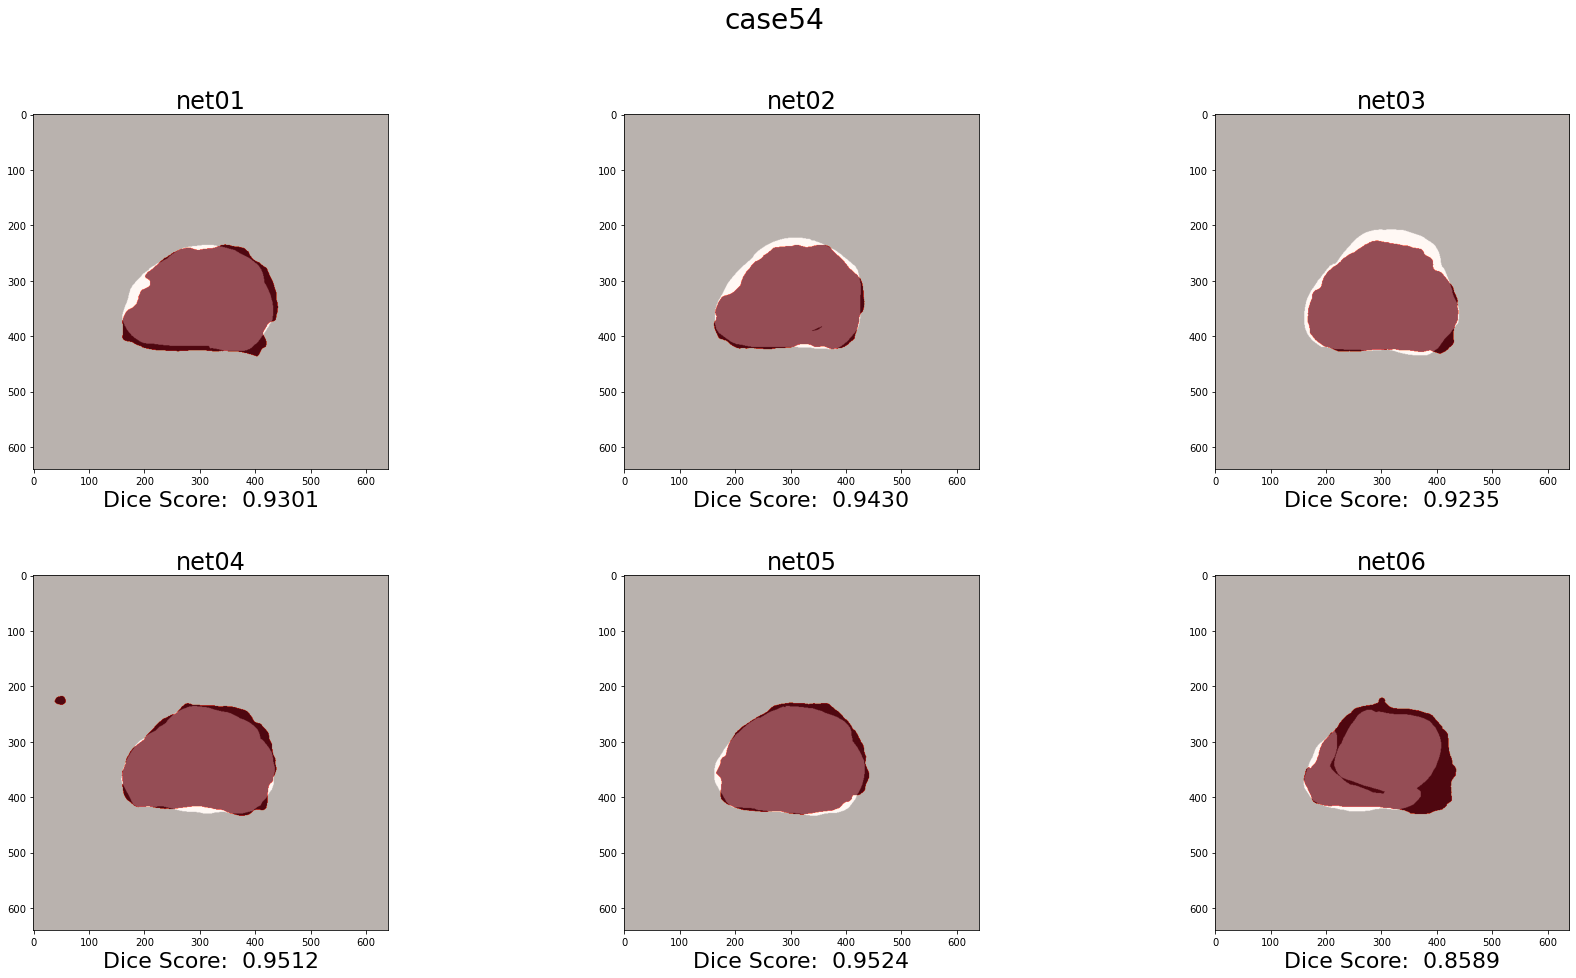

****************************************************************************************************


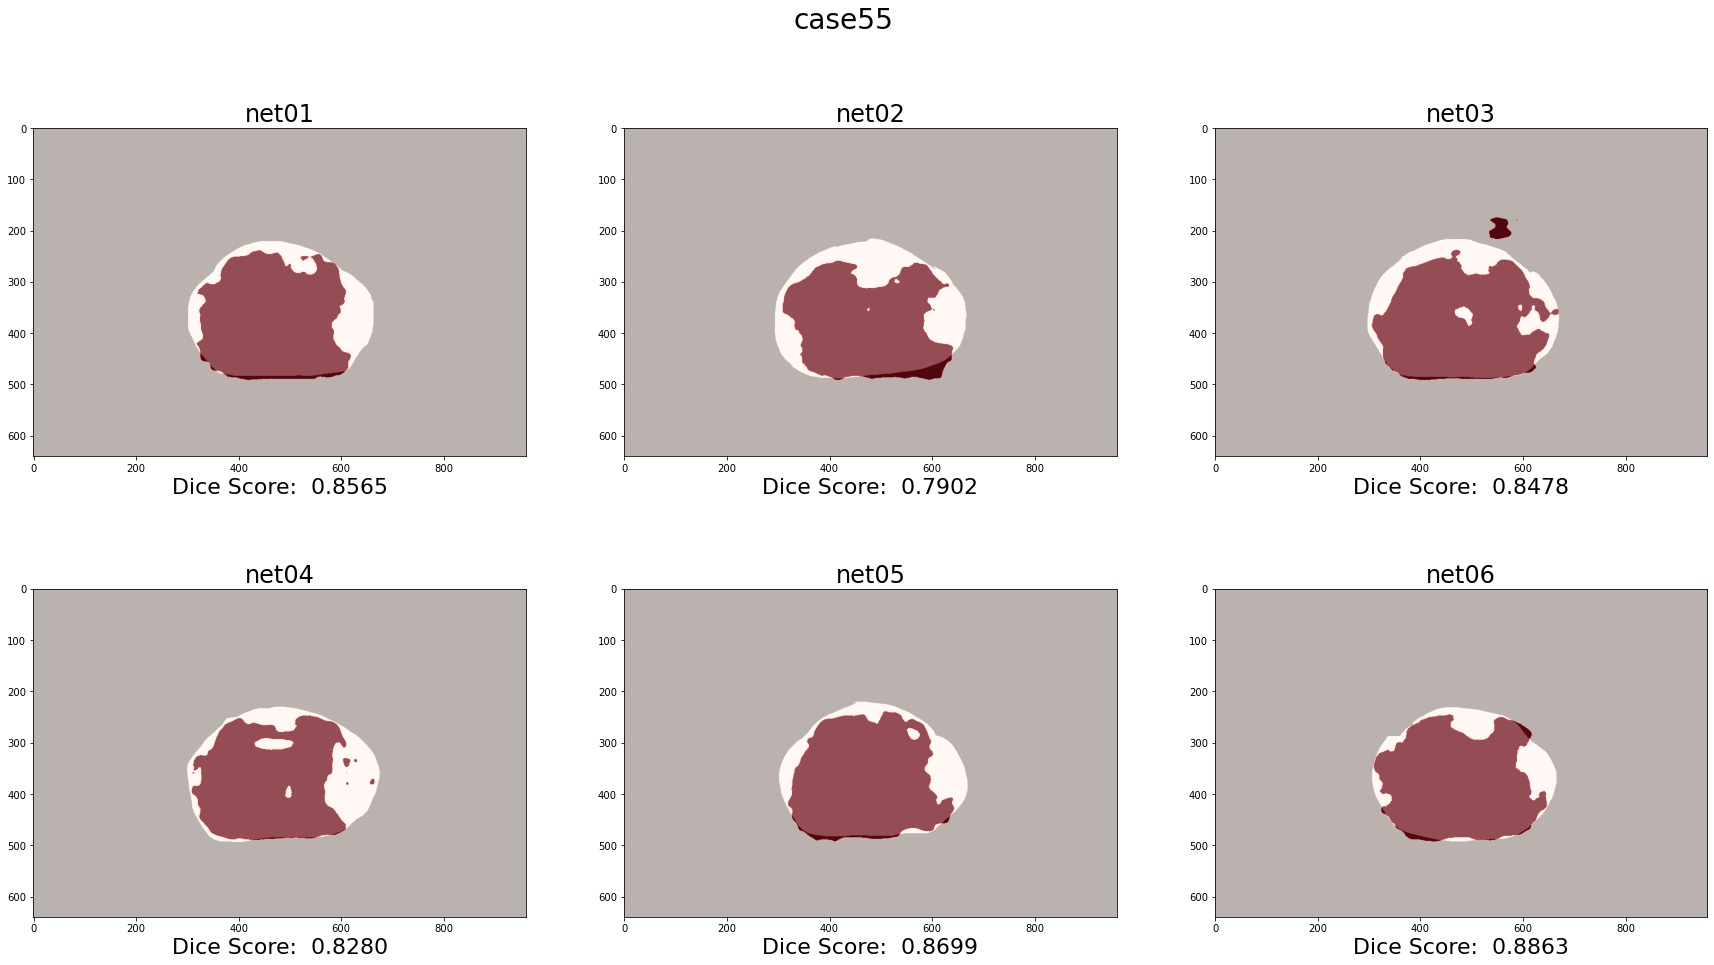

****************************************************************************************************


In [4]:
import warnings
warnings.filterwarnings('ignore')


for (outputs, gts), case in zip(single_net_loader, single_net_dicesheet.index):
    plt.figure(figsize=(30, 15))
    plt.subplots_adjust(hspace =0.3)
    for i in range(6):
        plt.subplot(2, 3, i+1)
        gt = np.array(gts[i].squeeze())
        output = np.array(outputs[i].squeeze())
        plt.imshow(gt, cmap="gray", alpha = 0.9)
        plt.imshow(output, cmap="Reds", alpha = 0.7)
        plt.title(f"net{i+1:02d}", fontsize=24)
        plt.xlabel(f'Dice Score: {single_net_dicesheet.loc[case, f"{i+1:02d}"] : .4f}', fontsize=22)
    plt.suptitle(case, fontsize=28)
    plt.savefig(os.path.join("./visualized-img/single_net", f"{case}.pdf"), dpi=300)
    plt.show()
    print('*'*100)

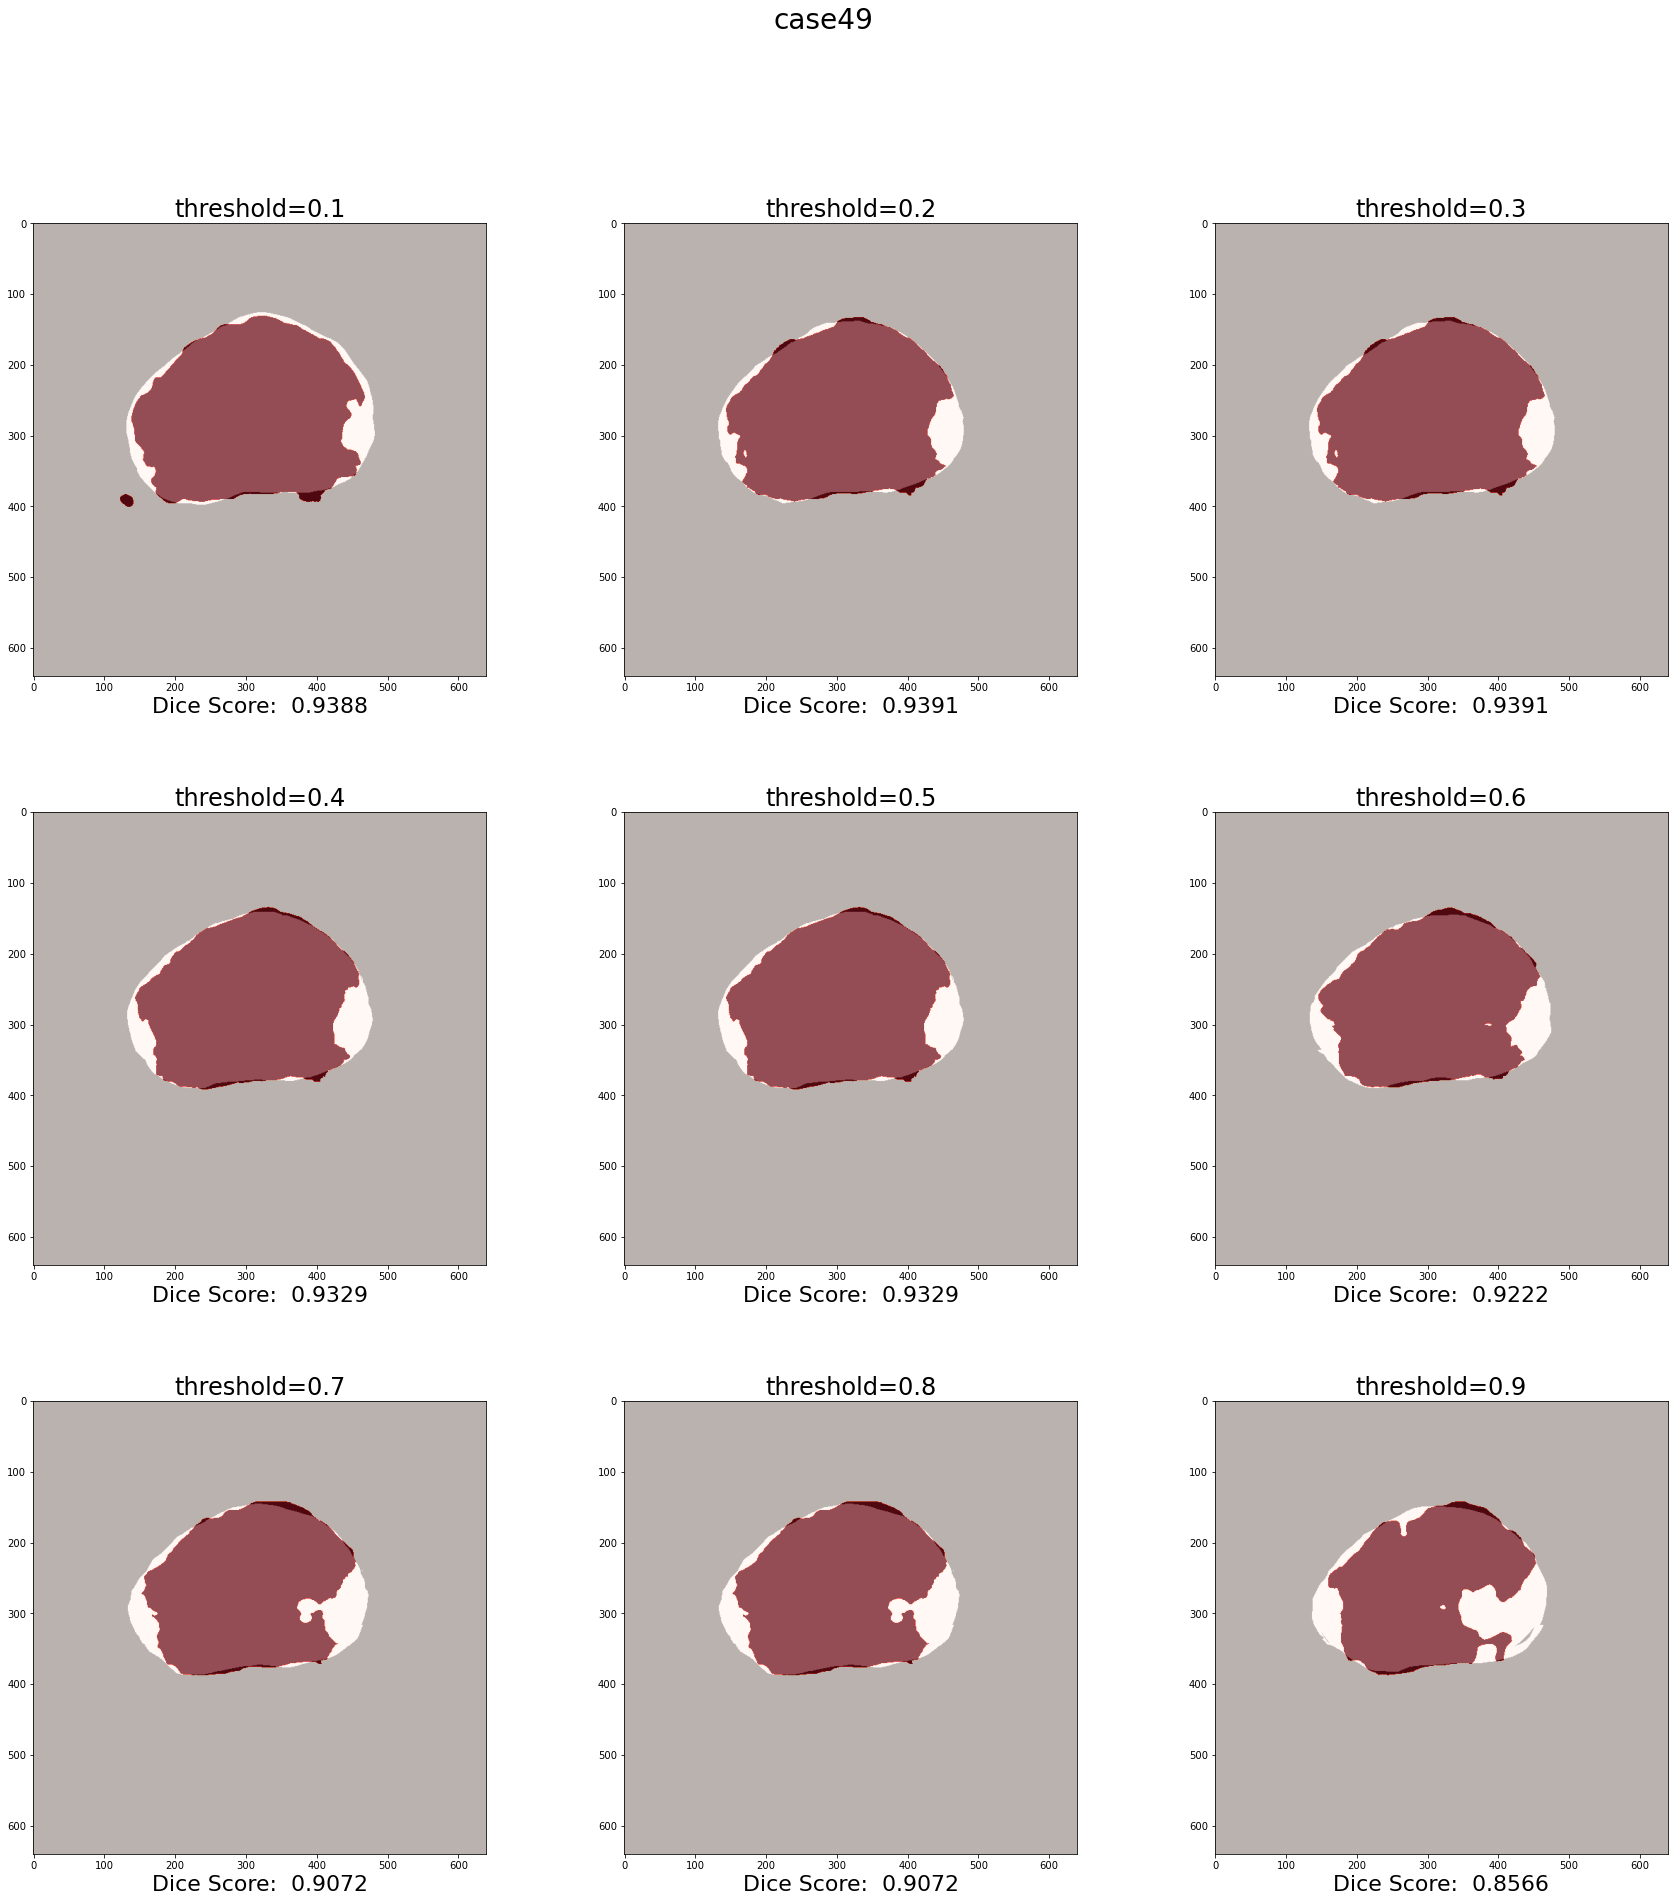

****************************************************************************************************


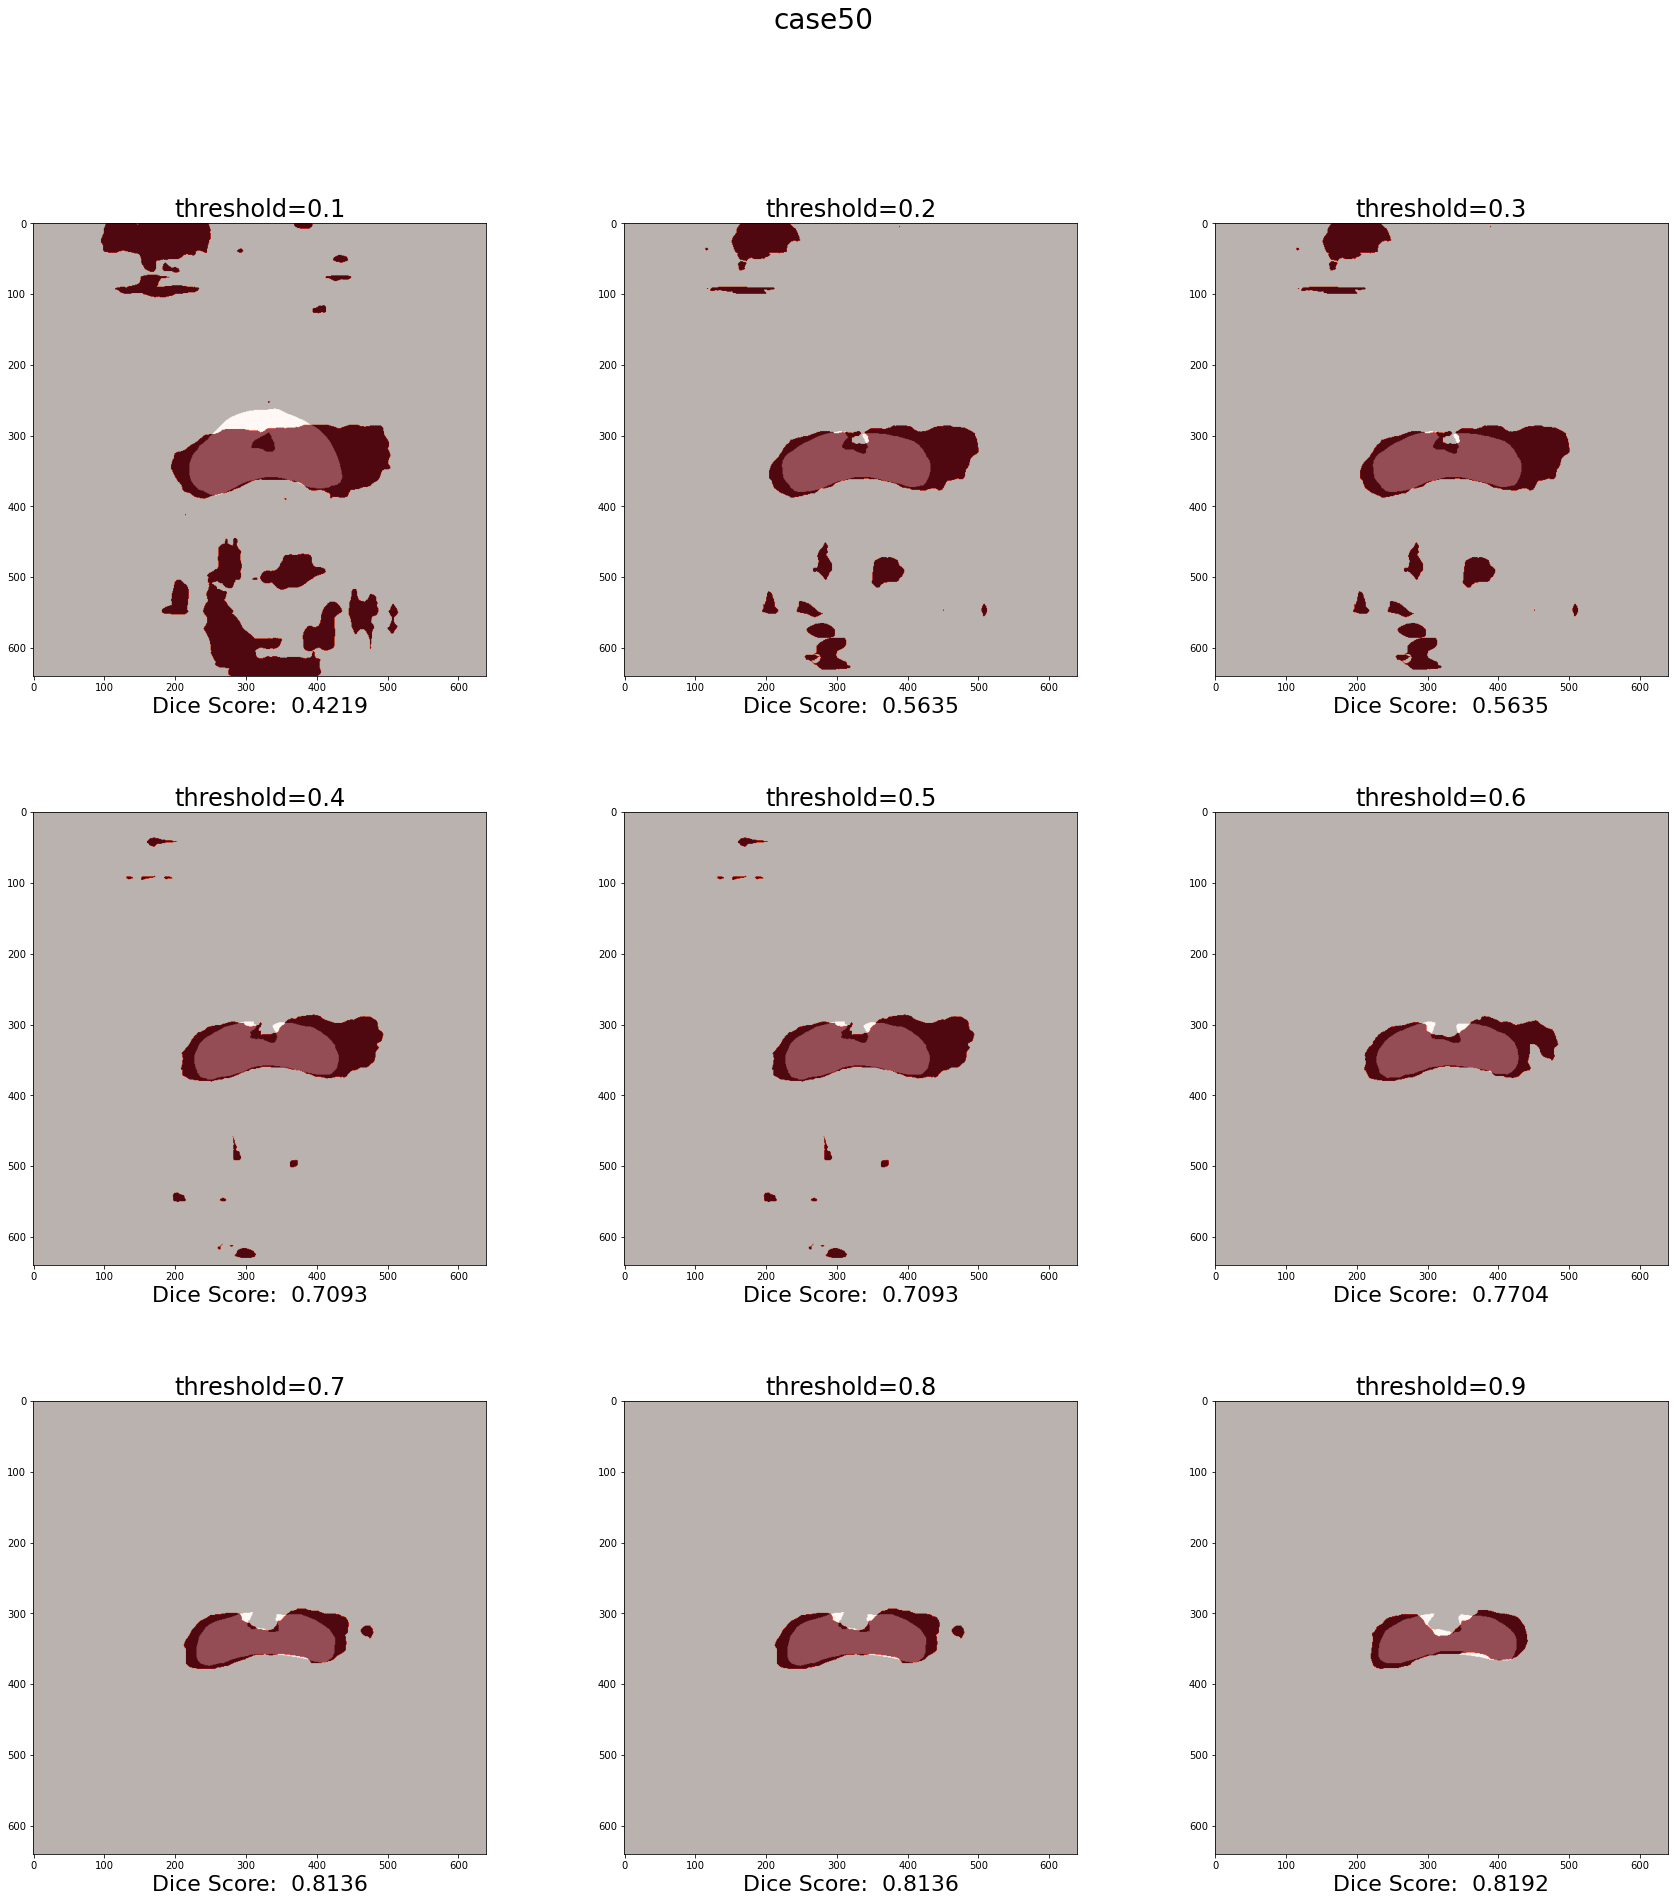

****************************************************************************************************


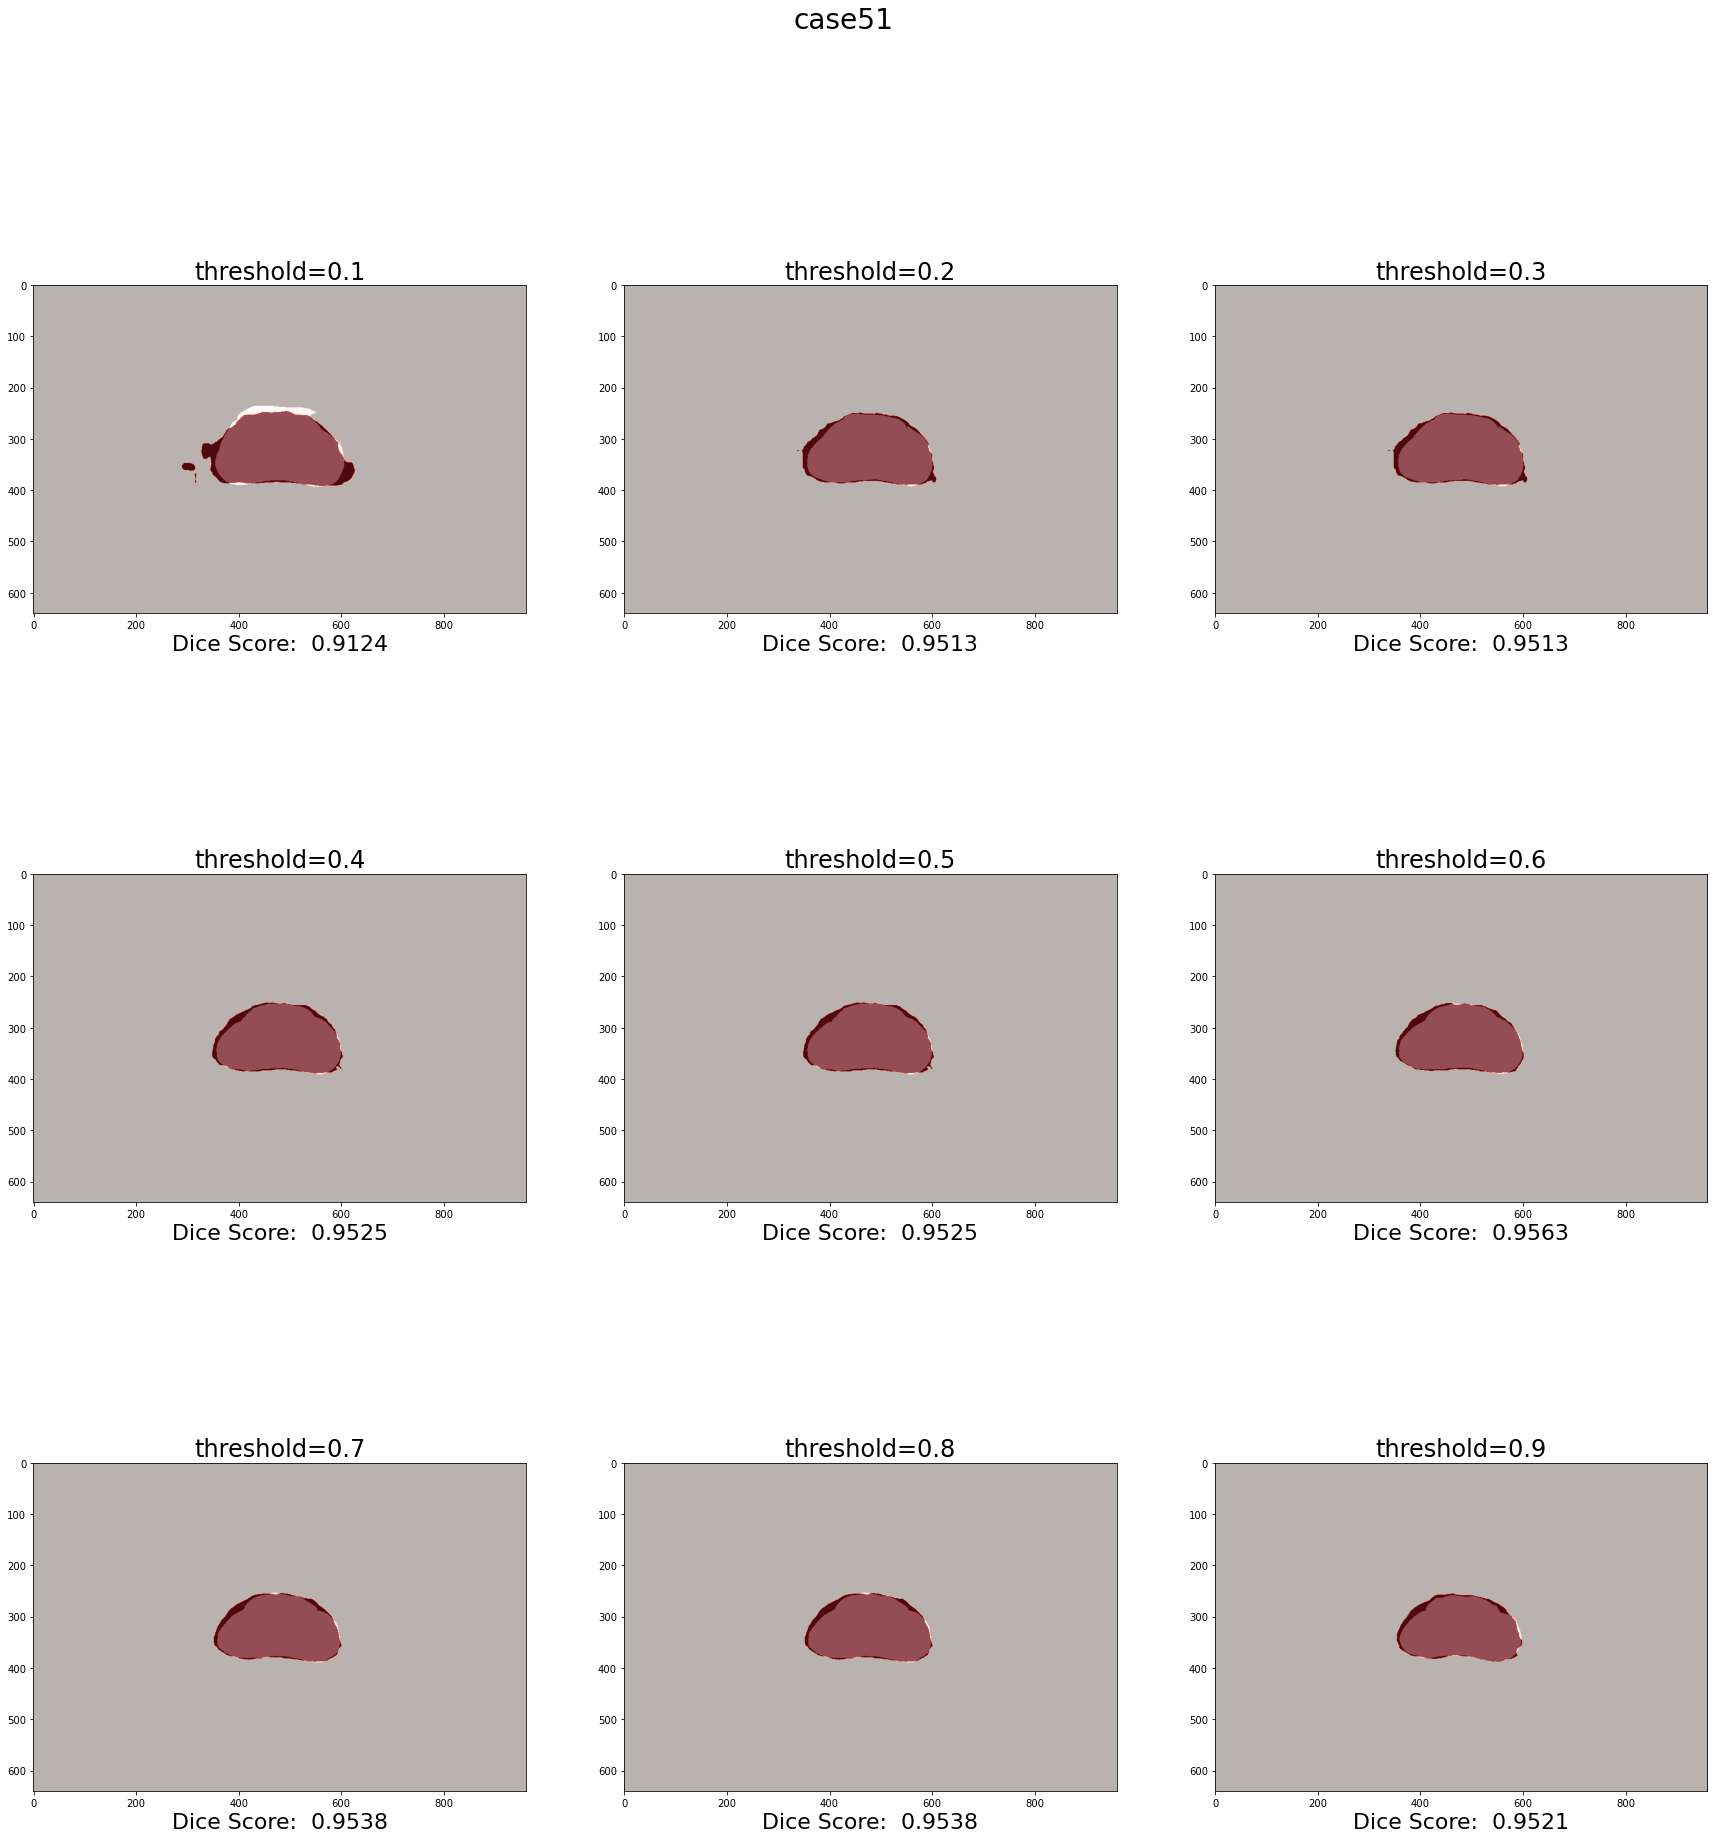

****************************************************************************************************


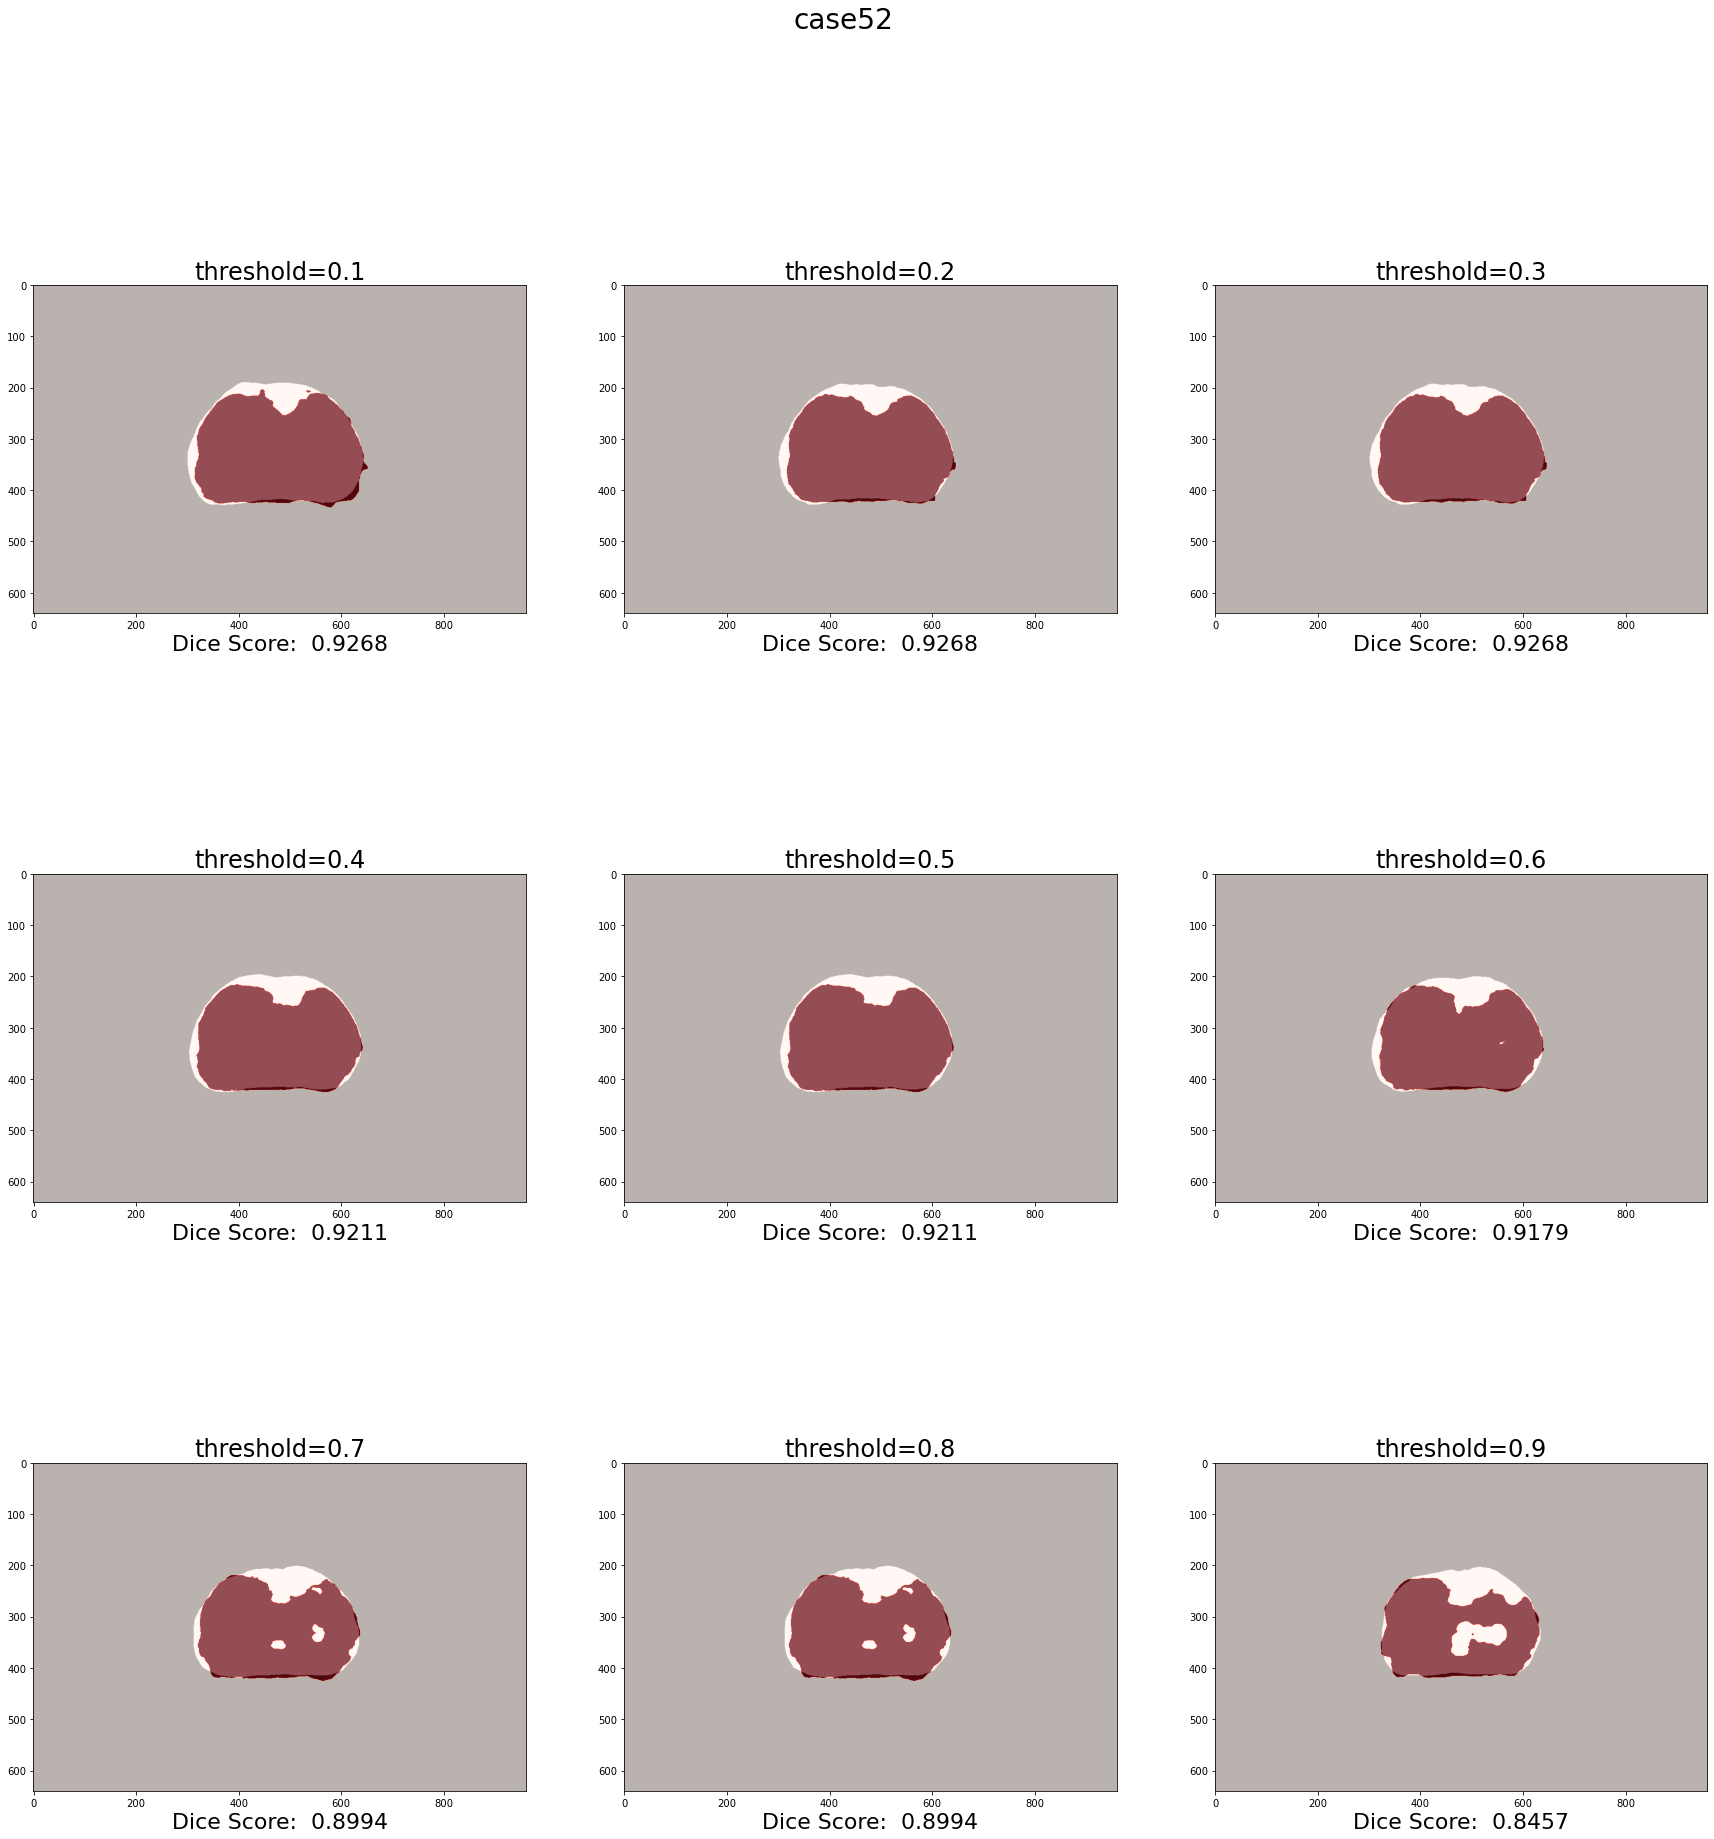

****************************************************************************************************


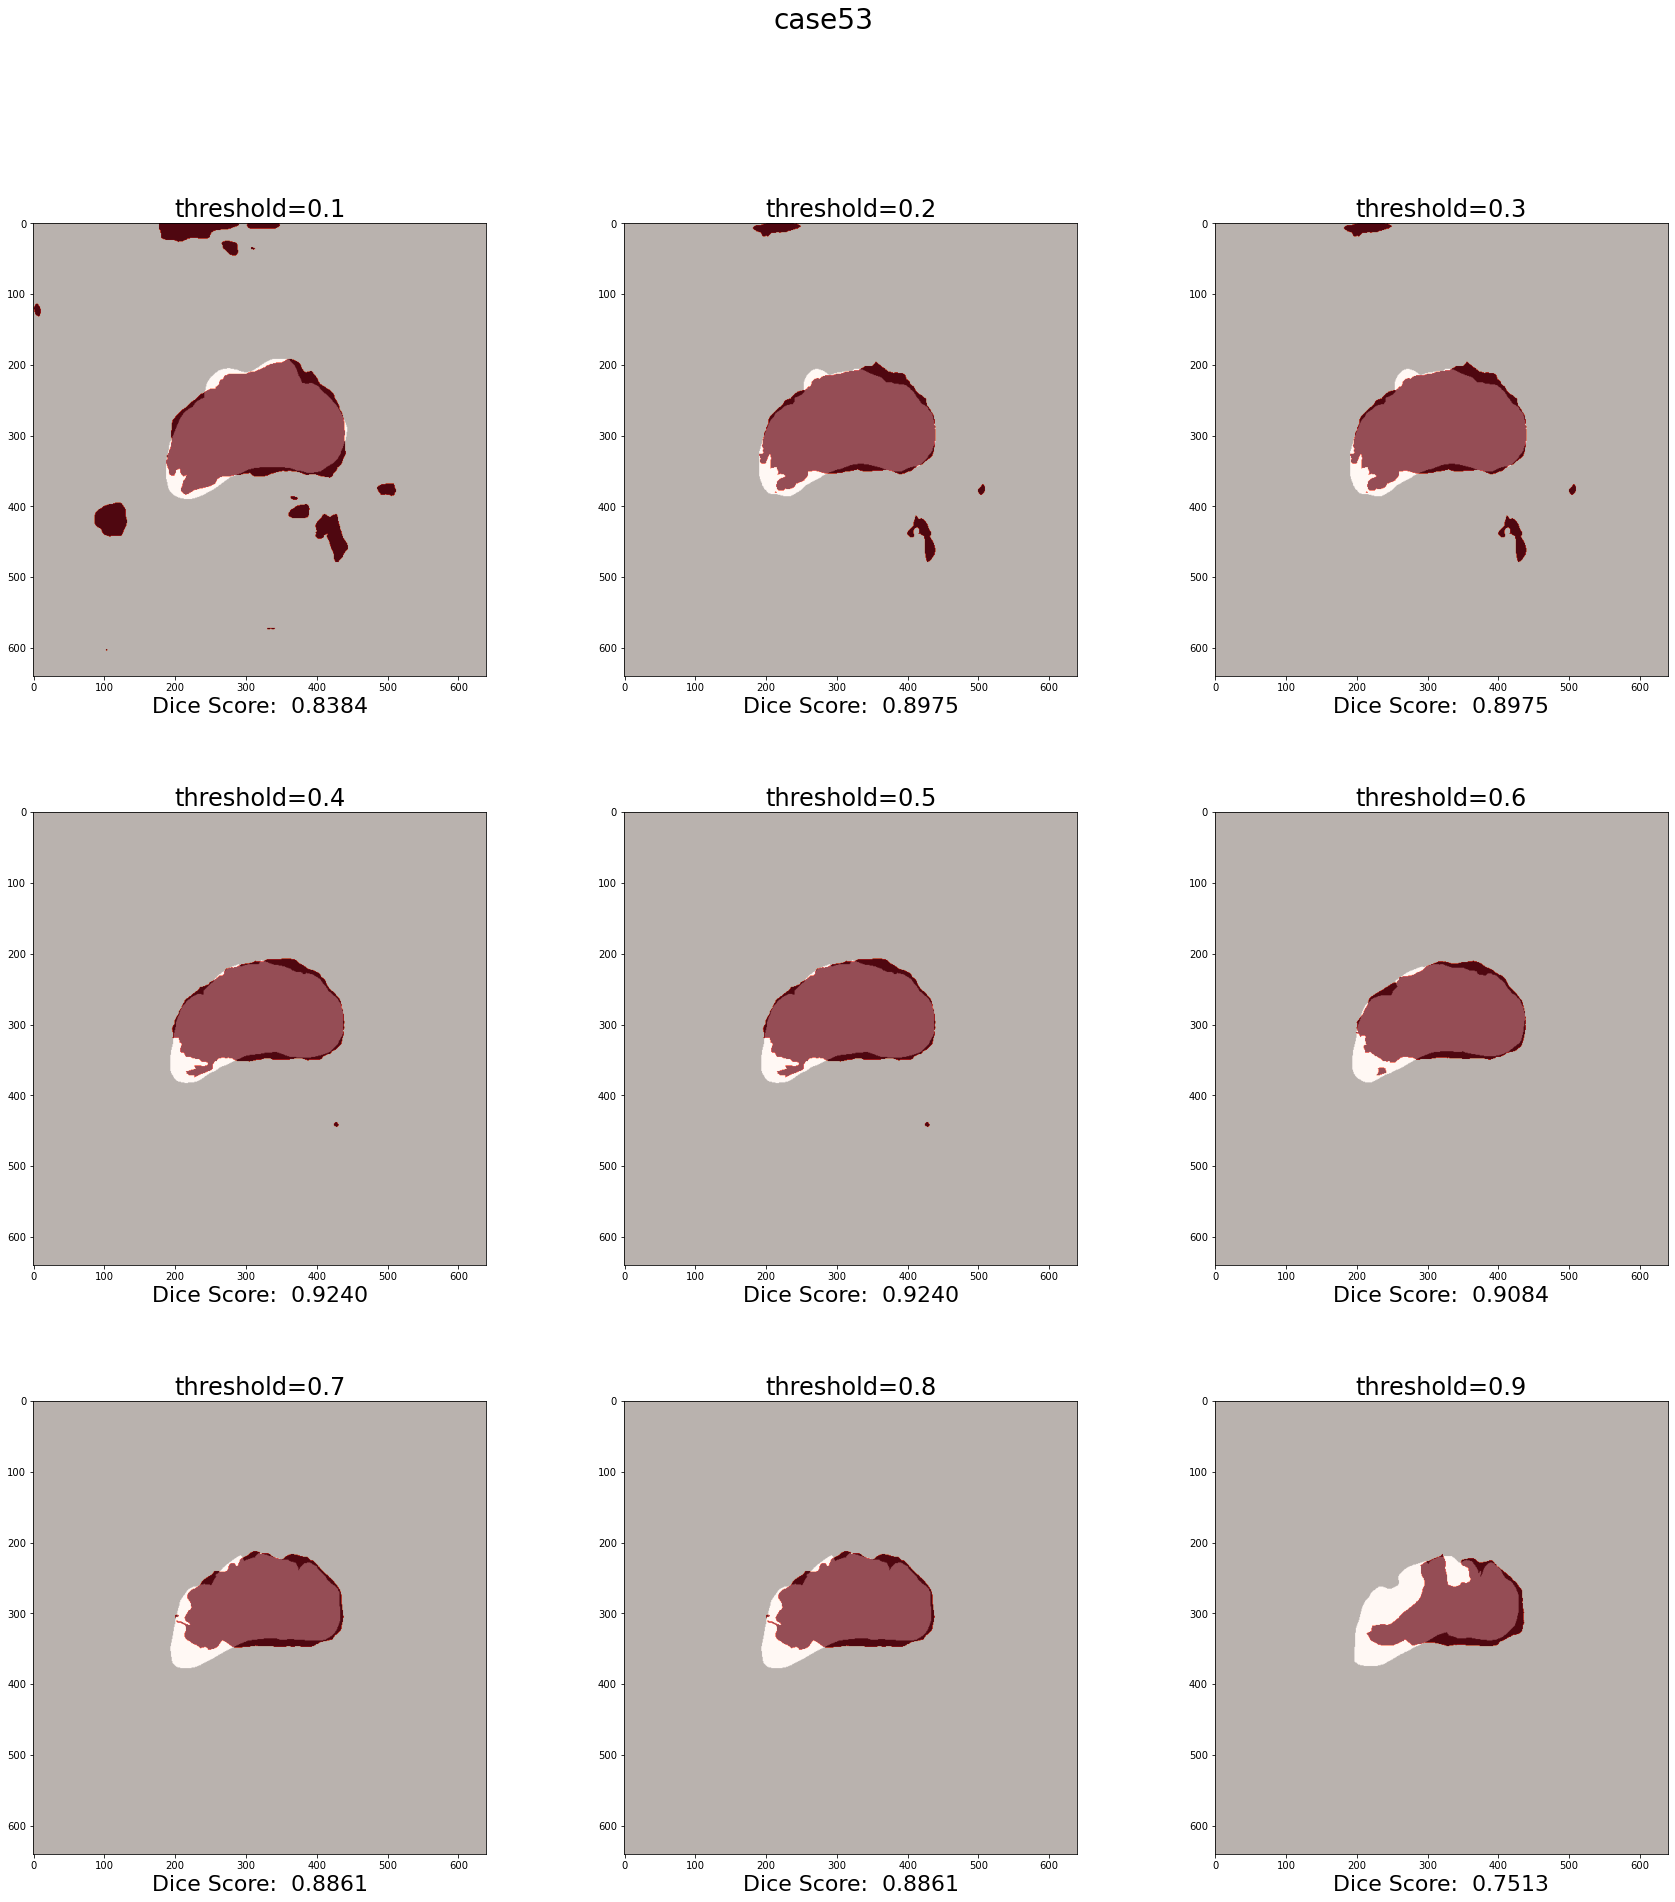

****************************************************************************************************


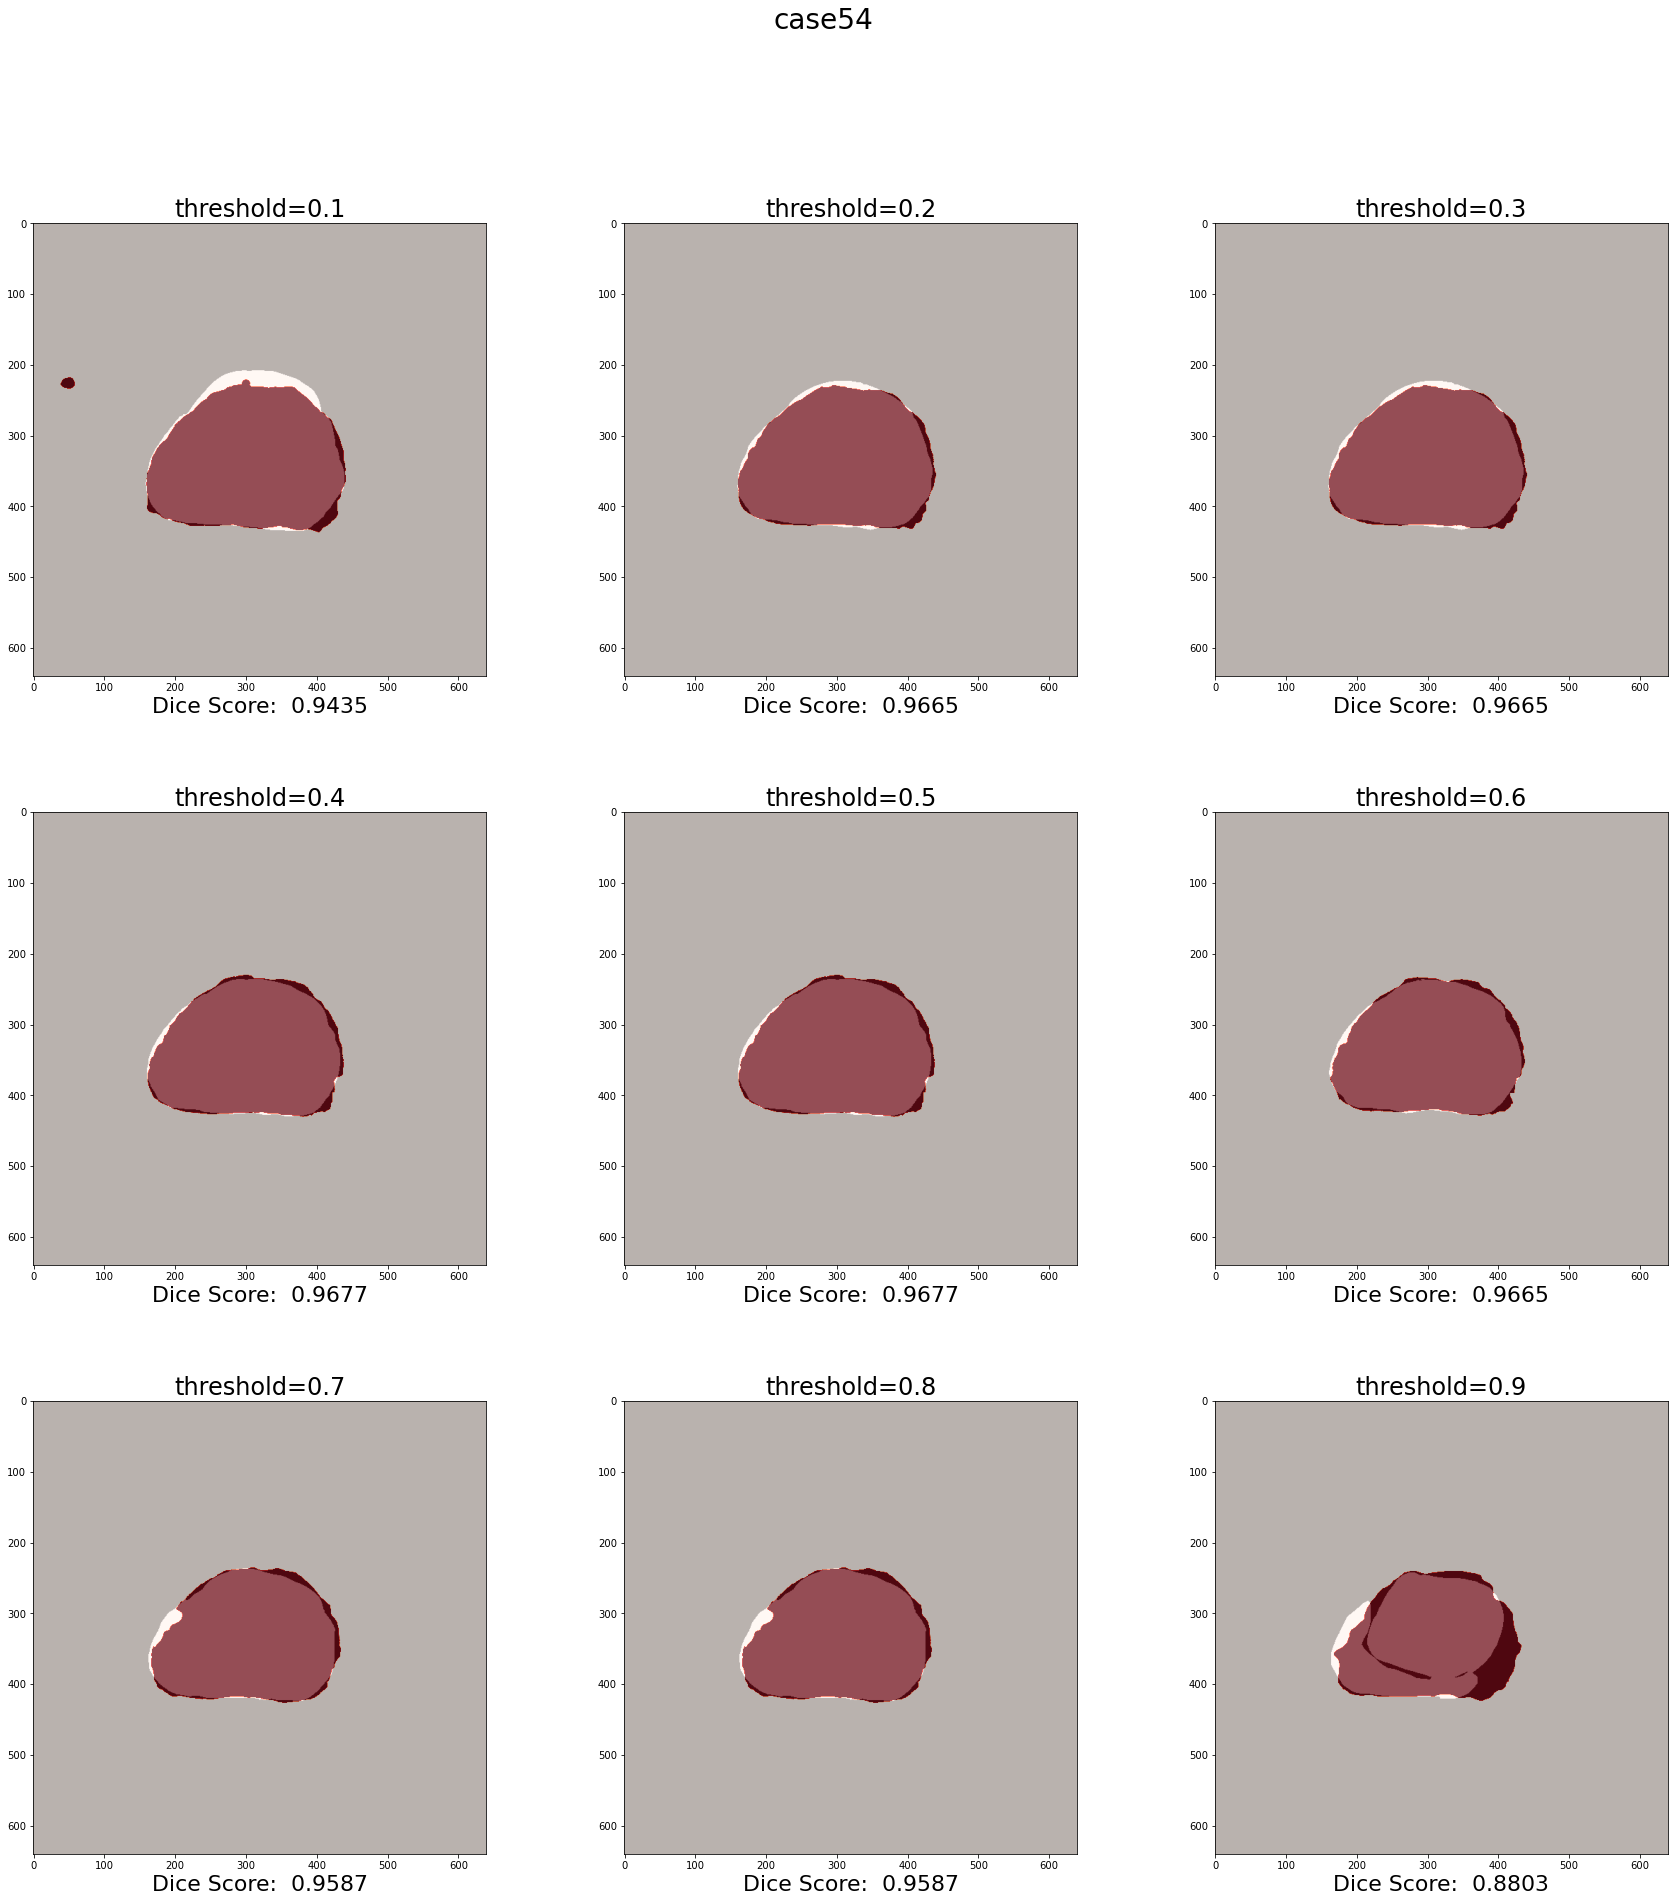

****************************************************************************************************


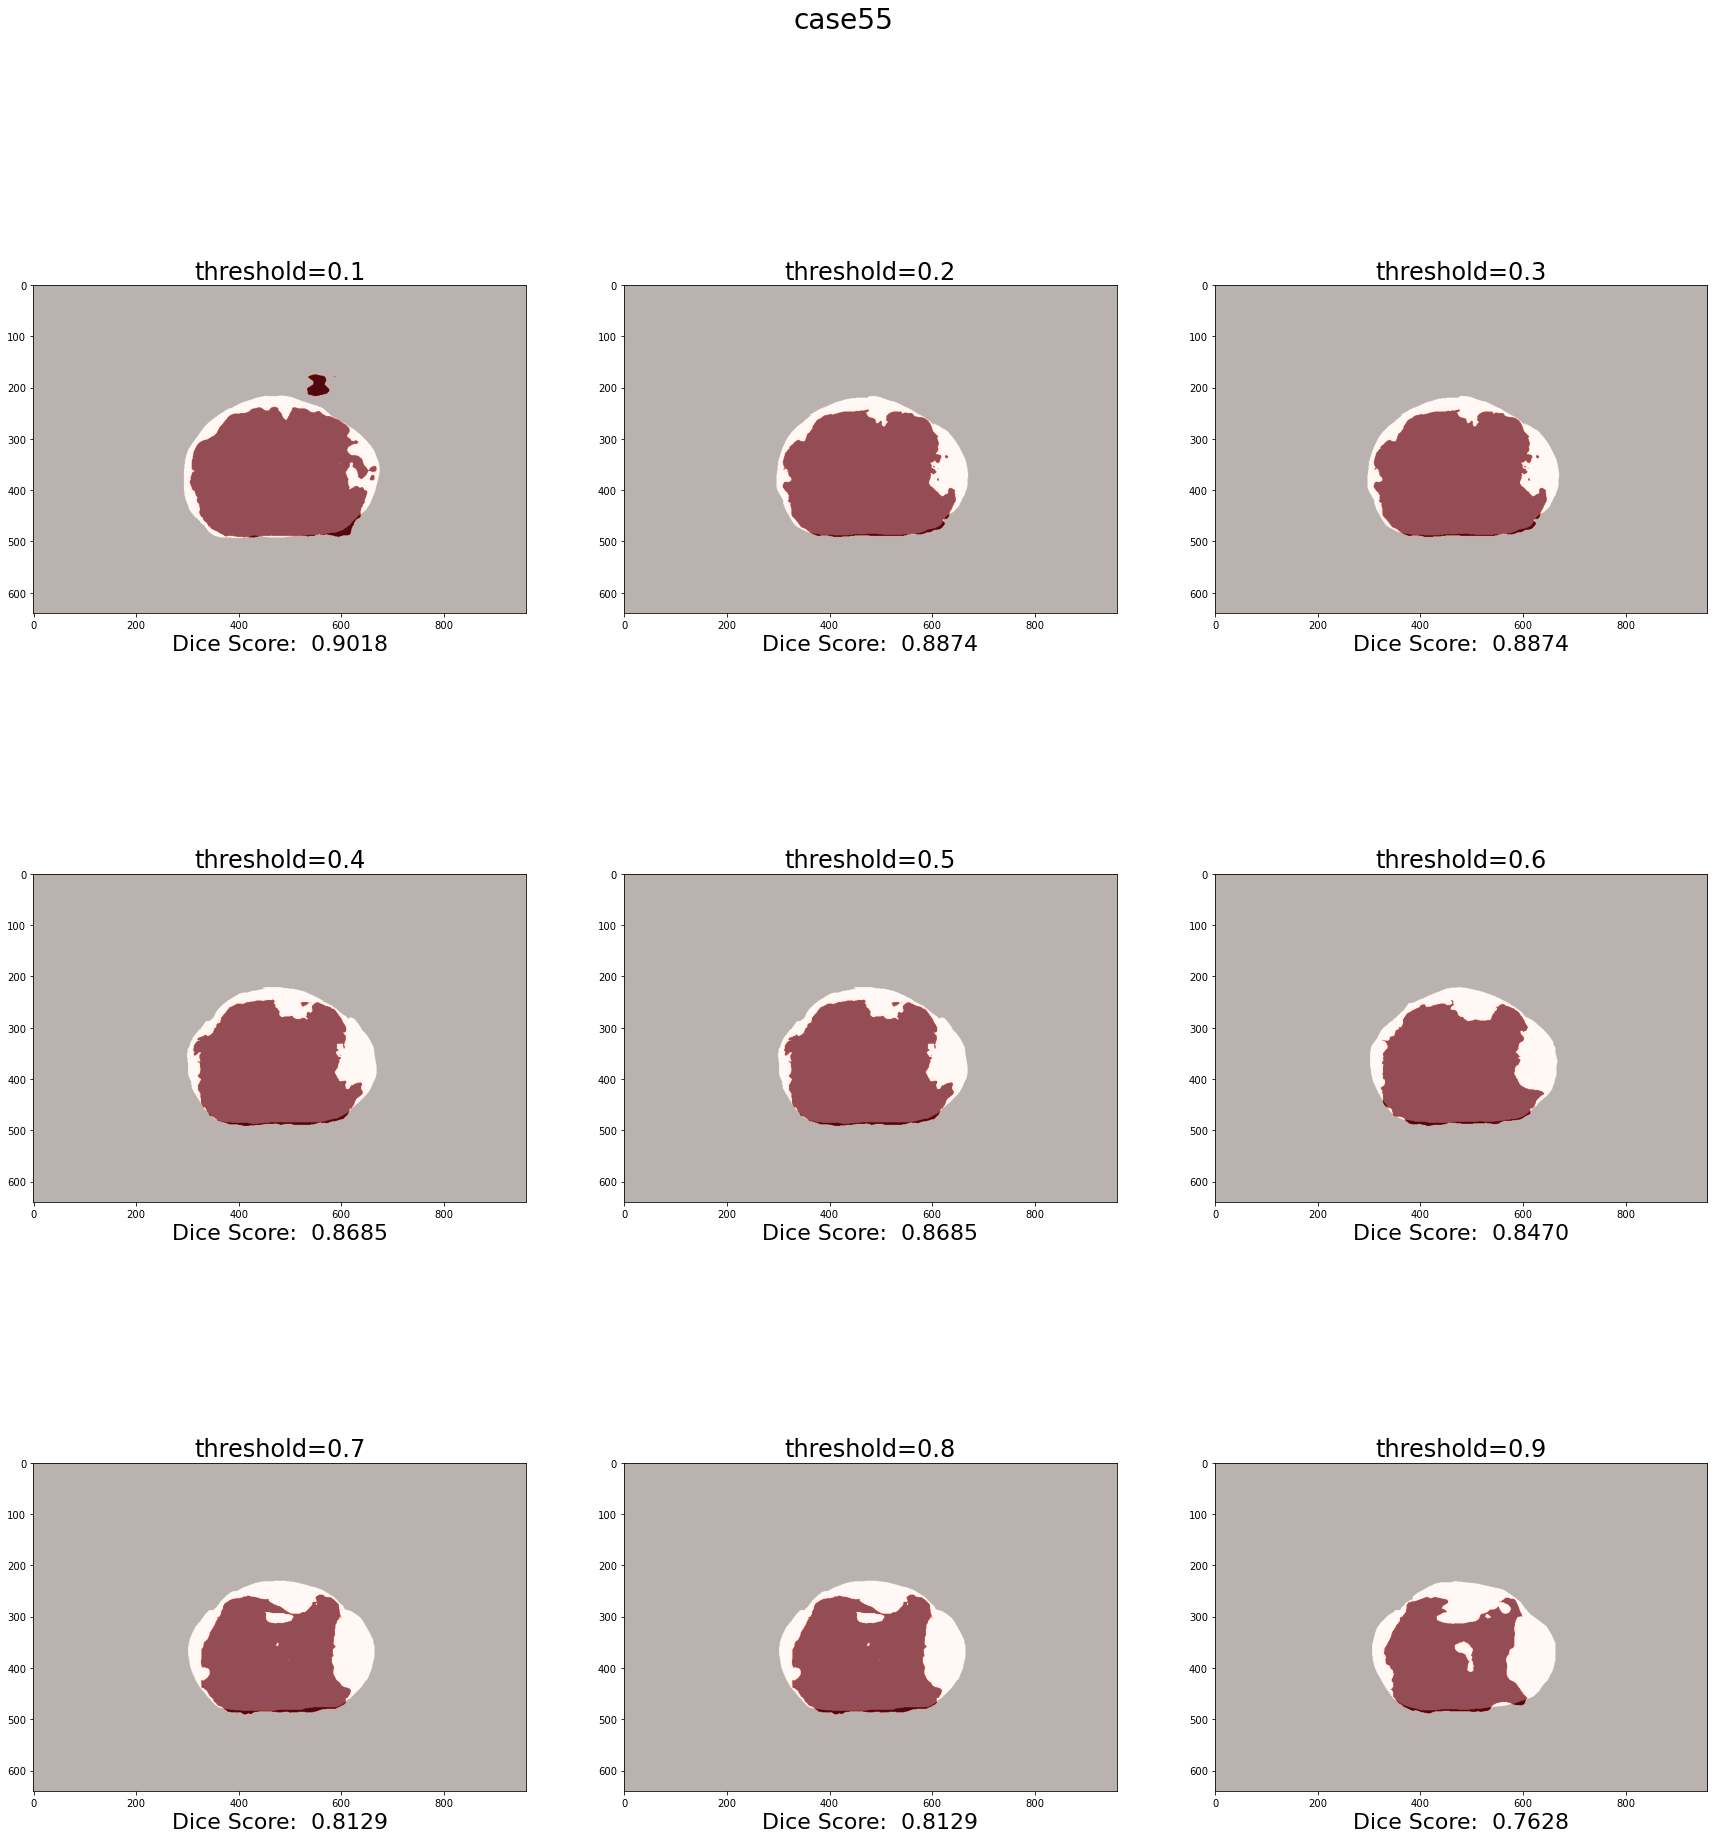

****************************************************************************************************


In [5]:
for (outputs, gts), case in zip(threshold_loader, threshold_dicesheet.index):
    plt.figure(figsize=(30, 30))
    plt.subplots_adjust(hspace =0.3)
    for i in range(9):
        plt.subplot(3, 3, i+1)
        gt = np.array(gts[i].squeeze())
        output = np.array(outputs[i].squeeze())
        plt.imshow(gt, cmap="gray", alpha = 0.9)
        plt.imshow(output, cmap="Reds", alpha = 0.7)
        plt.title(f"threshold=0.{i+1}", fontsize=24)
        plt.xlabel(f'Dice Score: {threshold_dicesheet.loc[case, f"0.{i+1}"] : .4f}', fontsize=22)
    plt.suptitle(case, fontsize=28)
    plt.savefig(os.path.join("./visualized-img/threshold", f"{case}.pdf"), dpi=300)
    plt.show()
    print('*'*100)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard